<a href="https://colab.research.google.com/github/Godjobgerry/Multi-cycle-Classification/blob/main/SHAP_Value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!pip install geemap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.1 MB/s eta 0:00:00


In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=KbS01ePXohS2bg7gidu5avgBaAdXU5amsIo9PqJp5R8&tc=p4k37RFE59qwF0bZD4oQn_bz7kXihkcwadiLlA1ZC68&cc=BAByDIm98s_FNSDSo5236Xxc0Bwji32vNAOeZ0vZPyo

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1Adeu5BW8x3C8J7mFNILV5jd6Rc3aEkNII8Is2DMGmcbbpxGcwzGdeERmwEg

Successfully saved authorization token.


In [ ]:
import geemap
import multiprocessing as mp
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import math
from google.colab import files
import matplotlib as mpl

In [ ]:
area = ee.FeatureCollection('projects/ee-gaoliaoran2020/assets/zhangZT/WeiGan_Basin')

# 逐步删除样本点

In [ ]:
baicheng = ee.FeatureCollection("projects/soil-salinization-map/assets/2018/baicheng")
kuche = ee.FeatureCollection("projects/soil-salinization-map/assets/2018/kuche")
shaya = ee.FeatureCollection("projects/soil-salinization-map/assets/2018/shaya")
xinhe = ee.FeatureCollection("projects/soil-salinization-map/assets/2018/xinhe")


# 选择样本
def renmoveProperty(feat):
  property = "Salinity"
  properties = feat.propertyNames()
  selectProperties = properties.filter(ee.Filter.eq('item', property))
  return feat.select(selectProperties)

def type_change(feature):
  pro = feature.get("Salinity")
  return feature.set("Salinity",ee.Number.parse(pro));

def sample0_2_add(feature):
    return feature.set("index",0);

def sample2_add(feature):
    return feature.set("index",1);

sample_point = ee.FeatureCollection(baicheng).merge(kuche).merge(shaya).merge(xinhe).filterBounds(area).map(type_change).map(renmoveProperty)
sample0_2 = sample_point.filter(ee.Filter.lt("Salinity",2)).filter(ee.Filter.gte("Salinity",0)).map(sample0_2_add).randomColumn('random',seed = 2)
sample2 = sample_point.filter(ee.Filter.gte("Salinity",2)).map(sample2_add).randomColumn('random',seed = 2)
train0_2 = sample0_2.filter(ee.Filter.lt('random', 0.7));
train2 = sample2.filter(ee.Filter.lt('random', 0.7));
test0_2 = sample0_2.filter(ee.Filter.gte('random', 0.7));
test2 = sample2.filter(ee.Filter.gte('random', 0.7));
train = train0_2.merge(train2)
test = test0_2.merge(test2)

In [ ]:
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()

In [ ]:
# 构建原始波段时间序列
def MSAVI(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def MSAVI(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      index = (Nir.multiply(2).add(1)).sqrt().divide(2).subtract((Nir.multiply(2).add(1).pow(2).subtract(Nir.subtract(Red).multiply(8))));
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(MSAVI).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image


MSAVIImage = MSAVI(start_time,end_time,day_gap,image_number,area,"MSAVI")
Image = MSAVIImage

Training = Image.sampleRegions(collection=train, scale=10, geometries=True);
Testing = Image.sampleRegions(collection=test, scale=10, geometries=True);
label = Image.bandNames().getInfo()
label.append("index")
label.append("Salinity")
label.append("Crop")
Training = pd.DataFrame(geemap.ee_to_pandas(Training, sort_columns=True), columns=label)
Testing = pd.DataFrame(geemap.ee_to_pandas(Testing, sort_columns=True), columns=label)

##### 方法三

In [ ]:
feat_labels = ['MSAVI_04', 'MSAVI_05', 'MSAVI_06', 'MSAVI_07', 'MSAVI_08', 'MSAVI_09', 'MSAVI_15', 'MSAVI_17', 'MSAVI_21', "index"]
x_train, x_test, y_train, y_test = Training[feat_labels].iloc[:, :-1].values, Testing[feat_labels].iloc[:, :-1].values, Training[feat_labels].iloc[:, -1].values, Testing[feat_labels].iloc[:, -1].values
regr1 = RandomForestClassifier(n_estimators=300, max_depth=18, min_samples_split=2, max_features=4/10, random_state=9)
regr1.fit(x_train, y_train)
pred = regr1.predict(x_test)
print(sklearn.metrics.f1_score(y_test, pred, average=None))

[0.74509804 0.64864865]


In [ ]:
# from geemap import ml

# feature_names = ['MSAVI_04', 'MSAVI_05', 'MSAVI_06', 'MSAVI_07', 'MSAVI_08', 'MSAVI_09', 'MSAVI_15', 'MSAVI_17', 'MSAVI_21']
# trees = ml.rf_to_strings(regr1, feature_names, output_mode="PROBABILITY")
# ee_strings = [ee.String(tree) for tree in trees]
# ee_classifier = ee.Classifier.decisionTreeEnsemble(ee_strings)
# # ee_classifier = ee_classifier.setOutputMode("MULTIPROBABILITY")
# New_image = Image.select(feature_names)
# Classification1 = New_image.classify(ee_classifier)

In [ ]:
all_sample = pd.concat([Training, Testing])
pred = regr1.predict(all_sample[feat_labels].iloc[:, :-1].values)
index = all_sample[feat_labels].iloc[:, -1].values
all_sample["pred"]=pred
all_sample

MSAVI_00  MSAVI_01  MSAVI_02  MSAVI_03  MSAVI_04  MSAVI_05  MSAVI_06  \
0   -1.443177 -2.328839 -3.147846 -1.567486 -1.507853 -1.989103 -1.768753   
1   -1.397696 -2.462918 -3.226290 -1.572161 -1.439297 -1.954079 -1.803138   
2   -1.477666 -3.052380 -2.621554 -1.642366 -1.586396 -1.559964 -1.711615   
3   -1.434657 -3.500195 -2.826284 -1.686044 -1.429272 -1.391663 -1.843519   
4   -1.294436 -3.062485 -2.561534 -1.777395 -1.358944 -1.355301 -1.805580   
..        ...       ...       ...       ...       ...       ...       ...   
127 -1.079527 -1.342551 -1.086530 -1.097254 -1.834536 -1.643730 -1.781226   
128 -1.406661 -1.762285 -1.786155 -1.078749 -1.391884 -1.645088 -1.574165   
129 -1.007936 -1.195040 -1.849682 -1.111339 -1.348911 -1.567920 -1.433893   
130 -1.336011 -1.467888 -2.613836 -1.351086 -1.596656 -1.833434 -1.787239   
131 -1.169003 -1.447723 -1.636474 -1.245597 -1.487901 -1.521681 -1.485584   

     MSAVI_07  MSAVI_08  MSAVI_09  ...  MSAVI_16  MSAVI_17  MSAVI_18  \
0   -1.568464 -1.985988 -2.123580  ... -0.399341 -0.672980 -1.273283   
1   -1.744143 -2.705014 -1.998795  ... -0.530168 -0.528279 -1.145421   
2   -1.369420 -3.298848 -1.822957  ... -1.040191 -1.167183 -1.019138   
3   -1.641471 -1.658889 -2.184012  ... -0.221559 -0.418191 -0.767302   
4   -1.341744 -1.268373 -1.910985  ... -0.197717 -0.573643 -1.135441   
..        ...       ...       ...  ...       ...       ...       ...   
127 -1.682639 -1.903037 -1.634182  ... -0.501867 -0.562281 -0.979033   
128 -1.429581 -1.765014 -1.338004  ... -0.374171 -0.574629 -0.991684   
129 -1.293538 -1.990072 -1.195239  ... -0.397213 -0.453644 -0.677066   
130 -1.746871 -2.105129 -1.726548  ... -0.518846 -0.806344 -1.110128   
131 -1.461102 -1.986236 -1.611552  ... -0.568183 -0.652812 -1.140242   

     MSAVI_19  MSAVI_20  MSAVI_21  index  Salinity  Crop  pred  
0   -2.012866 -1.368604 -1.367029      0      1.46   NaN     0  
1   -2.023702 -1.217303 -1.469282      0      1.53   NaN     0  
2   -1.539429 -2.708418 -1.326265      0      1.54   NaN     0  
3   -1.676392 -1.526315 -1.629170      0      1.95   NaN     0  
4   -1.816050 -1.145527 -1.379565      0      1.37   NaN     0  
..        ...       ...       ...    ...       ...   ...   ...  
127 -1.513916 -1.051013 -1.201494      1     12.80   NaN     1  
128 -1.733243 -0.959184 -1.143988      1     13.50   NaN     1  
129 -1.280261 -0.825361 -0.952018      1     13.60   NaN     1  
130 -1.655094 -1.066856 -1.286703      1     15.40   NaN     1  
131 -1.036203 -1.023587 -1.230440      1     16.60   NaN     1  

[424 rows x 26 columns]

In [ ]:
print(sklearn.metrics.f1_score(index, pred, average=None))

[0.91754757 0.896     ]


In [ ]:
disclasssample = all_sample[(all_sample['index'] != all_sample['pred']) & (all_sample['Salinity']<3) & (all_sample['Salinity']>1)]
rest_sample = pd.concat([all_sample,disclasssample])
rest_sample = rest_sample.drop_duplicates(keep=False)
all_sample = rest_sample
all_sample

MSAVI_00  MSAVI_01  MSAVI_02  MSAVI_03  MSAVI_04  MSAVI_05  MSAVI_06  \
0   -1.443177 -2.328839 -3.147846 -1.567486 -1.507853 -1.989103 -1.768753   
1   -1.397696 -2.462918 -3.226290 -1.572161 -1.439297 -1.954079 -1.803138   
2   -1.477666 -3.052380 -2.621554 -1.642366 -1.586396 -1.559964 -1.711615   
3   -1.434657 -3.500195 -2.826284 -1.686044 -1.429272 -1.391663 -1.843519   
4   -1.294436 -3.062485 -2.561534 -1.777395 -1.358944 -1.355301 -1.805580   
..        ...       ...       ...       ...       ...       ...       ...   
127 -1.079527 -1.342551 -1.086530 -1.097254 -1.834536 -1.643730 -1.781226   
128 -1.406661 -1.762285 -1.786155 -1.078749 -1.391884 -1.645088 -1.574165   
129 -1.007936 -1.195040 -1.849682 -1.111339 -1.348911 -1.567920 -1.433893   
130 -1.336011 -1.467888 -2.613836 -1.351086 -1.596656 -1.833434 -1.787239   
131 -1.169003 -1.447723 -1.636474 -1.245597 -1.487901 -1.521681 -1.485584   

     MSAVI_07  MSAVI_08  MSAVI_09  ...  MSAVI_16  MSAVI_17  MSAVI_18  \
0   -1.568464 -1.985988 -2.123580  ... -0.399341 -0.672980 -1.273283   
1   -1.744143 -2.705014 -1.998795  ... -0.530168 -0.528279 -1.145421   
2   -1.369420 -3.298848 -1.822957  ... -1.040191 -1.167183 -1.019138   
3   -1.641471 -1.658889 -2.184012  ... -0.221559 -0.418191 -0.767302   
4   -1.341744 -1.268373 -1.910985  ... -0.197717 -0.573643 -1.135441   
..        ...       ...       ...  ...       ...       ...       ...   
127 -1.682639 -1.903037 -1.634182  ... -0.501867 -0.562281 -0.979033   
128 -1.429581 -1.765014 -1.338004  ... -0.374171 -0.574629 -0.991684   
129 -1.293538 -1.990072 -1.195239  ... -0.397213 -0.453644 -0.677066   
130 -1.746871 -2.105129 -1.726548  ... -0.518846 -0.806344 -1.110128   
131 -1.461102 -1.986236 -1.611552  ... -0.568183 -0.652812 -1.140242   

     MSAVI_19  MSAVI_20  MSAVI_21  index  Salinity  Crop  pred  
0   -2.012866 -1.368604 -1.367029      0      1.46   NaN     0  
1   -2.023702 -1.217303 -1.469282      0      1.53   NaN     0  
2   -1.539429 -2.708418 -1.326265      0      1.54   NaN     0  
3   -1.676392 -1.526315 -1.629170      0      1.95   NaN     0  
4   -1.816050 -1.145527 -1.379565      0      1.37   NaN     0  
..        ...       ...       ...    ...       ...   ...   ...  
127 -1.513916 -1.051013 -1.201494      1     12.80   NaN     1  
128 -1.733243 -0.959184 -1.143988      1     13.50   NaN     1  
129 -1.280261 -0.825361 -0.952018      1     13.60   NaN     1  
130 -1.655094 -1.066856 -1.286703      1     15.40   NaN     1  
131 -1.036203 -1.023587 -1.230440      1     16.60   NaN     1  

[401 rows x 26 columns]

In [ ]:
from sklearn.utils import shuffle
all_sample = shuffle(all_sample, random_state=42)
all_sample

MSAVI_00  MSAVI_01  MSAVI_02  MSAVI_03  MSAVI_04  MSAVI_05  MSAVI_06  \
285 -1.083262 -1.629875 -2.173106 -1.273781 -1.664143 -1.617443 -1.526553   
281 -0.996266 -1.174327 -2.898906 -1.094964 -1.555900 -1.516557 -1.379189   
33  -1.225272 -1.900258 -3.067676 -1.275681 -1.709573 -1.441160 -1.241519   
211 -1.053239 -1.133332 -1.877476 -1.052804 -1.881267 -1.683373 -0.880793   
93  -1.040265 -1.211753 -1.680410 -1.068209 -1.384494 -2.689675 -1.063528   
..        ...       ...       ...       ...       ...       ...       ...   
71  -1.076488 -1.211177 -1.389911 -1.206158 -2.108634 -1.532395 -1.555035   
106 -1.170545 -1.257754 -2.592554 -1.199950 -1.543240 -2.171877 -1.317016   
270 -1.087450 -1.200788 -1.664187 -1.186060 -2.092803 -1.448530 -1.406550   
69  -0.997602 -1.191334 -1.314248 -1.155328 -1.480738 -1.553608 -1.532452   
102 -0.964131 -1.350308 -1.225801 -1.160615 -2.114681 -2.877231 -1.557331   

     MSAVI_07  MSAVI_08  MSAVI_09  ...  MSAVI_16  MSAVI_17  MSAVI_18  \
285 -1.478012 -1.827142 -1.462733  ... -0.345009 -0.521027 -0.988555   
281 -1.061062 -1.541523 -0.899437  ... -0.189232 -0.494558 -0.743756   
33  -1.592566 -1.559830 -1.072025  ... -0.190758 -0.449510 -1.014944   
211 -0.758950 -0.411208 -1.659548  ... -0.580054 -2.327580 -0.704747   
93  -0.897668 -0.549795 -1.734190  ... -0.625822 -0.830919 -0.600528   
..        ...       ...       ...  ...       ...       ...       ...   
71  -1.564877 -1.581115 -2.278408  ... -0.398065 -1.365849 -0.897678   
106 -1.235038 -1.104352 -1.927173  ... -0.540930 -1.484543 -0.828474   
270 -1.468208 -1.425656 -2.358019  ... -0.568726 -1.048894 -0.916902   
69  -1.317272 -1.668421 -1.300429  ... -0.580824 -0.804796 -0.947861   
102 -1.485856 -1.402789 -1.849768  ... -0.502108 -0.583394 -0.719478   

     MSAVI_19  MSAVI_20  MSAVI_21  index  Salinity  Crop  pred  
285 -1.423150 -0.877347 -1.042676      1      5.60   NaN     1  
281 -1.702769 -0.886476 -1.039990      1      4.90   NaN     1  
33  -2.527553 -0.989698 -1.283812      0      1.53   NaN     0  
211 -0.961545 -1.039984 -1.081494      1      2.20   NaN     1  
93  -0.804142 -0.865999 -1.177918      0      1.50   NaN     0  
..        ...       ...       ...    ...       ...   ...   ...  
71  -1.044954 -0.986328 -1.073868      0      1.20   NaN     0  
106 -0.959866 -0.982775 -1.015525      0      1.60   NaN     0  
270 -0.926293 -1.039898 -1.133224      1      9.56   NaN     1  
69  -1.237614 -0.973259 -1.176185      0      1.60   NaN     0  
102 -0.854305 -0.906719 -0.983344      0      1.20   NaN     0  

[401 rows x 26 columns]

In [ ]:
X, y = all_sample[feat_labels].iloc[:, :-1].values, all_sample[feat_labels].iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
regr2 = RandomForestClassifier(n_estimators=100, max_depth=9, min_samples_split=6, max_features=4/10, random_state=3)
regr2.fit(X_train, y_train)
pred = regr2.predict(X_test)
print(sklearn.metrics.f1_score(y_test, pred, average=None))

[0.8        0.72072072]


In [ ]:
# from geemap import ml

# feature_names = ['MSAVI_04', 'MSAVI_05', 'MSAVI_06', 'MSAVI_07', 'MSAVI_08', 'MSAVI_09', 'MSAVI_15', 'MSAVI_17', 'MSAVI_21']
# trees = ml.rf_to_strings(regr2, feature_names, output_mode="PROBABILITY")
# ee_strings = [ee.String(tree) for tree in trees]
# ee_classifier = ee.Classifier.decisionTreeEnsemble(ee_strings)
# # ee_classifier = ee_classifier.setOutputMode("CLASSIFICATION")
# New_image = Image.select(feature_names)
# Classification2 = New_image.classify(ee_classifier)

In [ ]:
pred = regr2.predict(all_sample[feat_labels].iloc[:, :-1].values)
index = all_sample[feat_labels].iloc[:, -1].values
all_sample["pred"]=pred
all_sample

MSAVI_00  MSAVI_01  MSAVI_02  MSAVI_03  MSAVI_04  MSAVI_05  MSAVI_06  \
285 -1.083262 -1.629875 -2.173106 -1.273781 -1.664143 -1.617443 -1.526553   
281 -0.996266 -1.174327 -2.898906 -1.094964 -1.555900 -1.516557 -1.379189   
33  -1.225272 -1.900258 -3.067676 -1.275681 -1.709573 -1.441160 -1.241519   
211 -1.053239 -1.133332 -1.877476 -1.052804 -1.881267 -1.683373 -0.880793   
93  -1.040265 -1.211753 -1.680410 -1.068209 -1.384494 -2.689675 -1.063528   
..        ...       ...       ...       ...       ...       ...       ...   
71  -1.076488 -1.211177 -1.389911 -1.206158 -2.108634 -1.532395 -1.555035   
106 -1.170545 -1.257754 -2.592554 -1.199950 -1.543240 -2.171877 -1.317016   
270 -1.087450 -1.200788 -1.664187 -1.186060 -2.092803 -1.448530 -1.406550   
69  -0.997602 -1.191334 -1.314248 -1.155328 -1.480738 -1.553608 -1.532452   
102 -0.964131 -1.350308 -1.225801 -1.160615 -2.114681 -2.877231 -1.557331   

     MSAVI_07  MSAVI_08  MSAVI_09  ...  MSAVI_16  MSAVI_17  MSAVI_18  \
285 -1.478012 -1.827142 -1.462733  ... -0.345009 -0.521027 -0.988555   
281 -1.061062 -1.541523 -0.899437  ... -0.189232 -0.494558 -0.743756   
33  -1.592566 -1.559830 -1.072025  ... -0.190758 -0.449510 -1.014944   
211 -0.758950 -0.411208 -1.659548  ... -0.580054 -2.327580 -0.704747   
93  -0.897668 -0.549795 -1.734190  ... -0.625822 -0.830919 -0.600528   
..        ...       ...       ...  ...       ...       ...       ...   
71  -1.564877 -1.581115 -2.278408  ... -0.398065 -1.365849 -0.897678   
106 -1.235038 -1.104352 -1.927173  ... -0.540930 -1.484543 -0.828474   
270 -1.468208 -1.425656 -2.358019  ... -0.568726 -1.048894 -0.916902   
69  -1.317272 -1.668421 -1.300429  ... -0.580824 -0.804796 -0.947861   
102 -1.485856 -1.402789 -1.849768  ... -0.502108 -0.583394 -0.719478   

     MSAVI_19  MSAVI_20  MSAVI_21  index  Salinity  Crop  pred  
285 -1.423150 -0.877347 -1.042676      1      5.60   NaN     1  
281 -1.702769 -0.886476 -1.039990      1      4.90   NaN     0  
33  -2.527553 -0.989698 -1.283812      0      1.53   NaN     0  
211 -0.961545 -1.039984 -1.081494      1      2.20   NaN     1  
93  -0.804142 -0.865999 -1.177918      0      1.50   NaN     0  
..        ...       ...       ...    ...       ...   ...   ...  
71  -1.044954 -0.986328 -1.073868      0      1.20   NaN     1  
106 -0.959866 -0.982775 -1.015525      0      1.60   NaN     0  
270 -0.926293 -1.039898 -1.133224      1      9.56   NaN     1  
69  -1.237614 -0.973259 -1.176185      0      1.60   NaN     0  
102 -0.854305 -0.906719 -0.983344      0      1.20   NaN     1  

[401 rows x 26 columns]

In [ ]:
pred = all_sample["pred"].values
index = all_sample[["index"]].values
print(sklearn.metrics.f1_score(index, pred, average=None))

[0.92027335 0.90358127]


In [ ]:
newdisclasssample = all_sample[(all_sample['index'] != all_sample['pred']) & (all_sample['Salinity']<3) & (all_sample['Salinity']>1)]
disclasssample = pd.concat([disclasssample, newdisclasssample])
rest_sample = pd.concat([all_sample,newdisclasssample])
rest_sample = rest_sample.drop_duplicates(keep=False)
all_sample = rest_sample
all_sample

MSAVI_00  MSAVI_01  MSAVI_02  MSAVI_03  MSAVI_04  MSAVI_05  MSAVI_06  \
285 -1.083262 -1.629875 -2.173106 -1.273781 -1.664143 -1.617443 -1.526553   
281 -0.996266 -1.174327 -2.898906 -1.094964 -1.555900 -1.516557 -1.379189   
33  -1.225272 -1.900258 -3.067676 -1.275681 -1.709573 -1.441160 -1.241519   
211 -1.053239 -1.133332 -1.877476 -1.052804 -1.881267 -1.683373 -0.880793   
93  -1.040265 -1.211753 -1.680410 -1.068209 -1.384494 -2.689675 -1.063528   
..        ...       ...       ...       ...       ...       ...       ...   
131 -1.169003 -1.447723 -1.636474 -1.245597 -1.487901 -1.521681 -1.485584   
20  -1.408114 -1.475533 -3.368358 -1.414765 -1.427173 -1.675392 -1.430020   
106 -1.170545 -1.257754 -2.592554 -1.199950 -1.543240 -2.171877 -1.317016   
270 -1.087450 -1.200788 -1.664187 -1.186060 -2.092803 -1.448530 -1.406550   
69  -0.997602 -1.191334 -1.314248 -1.155328 -1.480738 -1.553608 -1.532452   

     MSAVI_07  MSAVI_08  MSAVI_09  ...  MSAVI_16  MSAVI_17  MSAVI_18  \
285 -1.478012 -1.827142 -1.462733  ... -0.345009 -0.521027 -0.988555   
281 -1.061062 -1.541523 -0.899437  ... -0.189232 -0.494558 -0.743756   
33  -1.592566 -1.559830 -1.072025  ... -0.190758 -0.449510 -1.014944   
211 -0.758950 -0.411208 -1.659548  ... -0.580054 -2.327580 -0.704747   
93  -0.897668 -0.549795 -1.734190  ... -0.625822 -0.830919 -0.600528   
..        ...       ...       ...  ...       ...       ...       ...   
131 -1.461102 -1.986236 -1.611552  ... -0.568183 -0.652812 -1.140242   
20  -1.313221 -1.202484 -0.756771  ... -1.252472 -1.221581 -1.289397   
106 -1.235038 -1.104352 -1.927173  ... -0.540930 -1.484543 -0.828474   
270 -1.468208 -1.425656 -2.358019  ... -0.568726 -1.048894 -0.916902   
69  -1.317272 -1.668421 -1.300429  ... -0.580824 -0.804796 -0.947861   

     MSAVI_19  MSAVI_20  MSAVI_21  index  Salinity  Crop  pred  
285 -1.423150 -0.877347 -1.042676      1      5.60   NaN     1  
281 -1.702769 -0.886476 -1.039990      1      4.90   NaN     0  
33  -2.527553 -0.989698 -1.283812      0      1.53   NaN     0  
211 -0.961545 -1.039984 -1.081494      1      2.20   NaN     1  
93  -0.804142 -0.865999 -1.177918      0      1.50   NaN     0  
..        ...       ...       ...    ...       ...   ...   ...  
131 -1.036203 -1.023587 -1.230440      1     16.60   NaN     1  
20  -2.221497 -1.375755 -1.492898      0      1.72   NaN     0  
106 -0.959866 -0.982775 -1.015525      0      1.60   NaN     0  
270 -0.926293 -1.039898 -1.133224      1      9.56   NaN     1  
69  -1.237614 -0.973259 -1.176185      0      1.60   NaN     0  

[384 rows x 26 columns]

In [ ]:
X, y = all_sample[feat_labels].iloc[:, :-1].values, all_sample[feat_labels].iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
regr3 = RandomForestClassifier(n_estimators=200, max_depth=4, min_samples_split=12, max_features=3/10, random_state=5)
regr3.fit(X_train, y_train)
pred = regr3.predict(X_test)
print(sklearn.metrics.f1_score(y_test, pred, average=None))

[0.70588235 0.66101695]


In [ ]:
# # from geemap import ml

# feature_names = ['MSAVI_04', 'MSAVI_05', 'MSAVI_06', 'MSAVI_07', 'MSAVI_08', 'MSAVI_09', 'MSAVI_15', 'MSAVI_17', 'MSAVI_21']
# trees = ml.rf_to_strings(regr3, feature_names, output_mode="PROBABILITY")
# ee_strings = [ee.String(tree) for tree in trees]
# ee_classifier = ee.Classifier.decisionTreeEnsemble(ee_strings)
# # ee_classifier = ee_classifier.setOutputMode("CLASSIFICATION")
# New_image = Image.select(feature_names)
# Classification3 = New_image.classify(ee_classifier)

In [ ]:
pred = regr3.predict(all_sample[feat_labels].iloc[:, :-1].values)
index = all_sample[feat_labels].iloc[:, -1].values
all_sample["pred"]=pred
all_sample

MSAVI_00  MSAVI_01  MSAVI_02  MSAVI_03  MSAVI_04  MSAVI_05  MSAVI_06  \
285 -1.083262 -1.629875 -2.173106 -1.273781 -1.664143 -1.617443 -1.526553   
281 -0.996266 -1.174327 -2.898906 -1.094964 -1.555900 -1.516557 -1.379189   
33  -1.225272 -1.900258 -3.067676 -1.275681 -1.709573 -1.441160 -1.241519   
211 -1.053239 -1.133332 -1.877476 -1.052804 -1.881267 -1.683373 -0.880793   
93  -1.040265 -1.211753 -1.680410 -1.068209 -1.384494 -2.689675 -1.063528   
..        ...       ...       ...       ...       ...       ...       ...   
131 -1.169003 -1.447723 -1.636474 -1.245597 -1.487901 -1.521681 -1.485584   
20  -1.408114 -1.475533 -3.368358 -1.414765 -1.427173 -1.675392 -1.430020   
106 -1.170545 -1.257754 -2.592554 -1.199950 -1.543240 -2.171877 -1.317016   
270 -1.087450 -1.200788 -1.664187 -1.186060 -2.092803 -1.448530 -1.406550   
69  -0.997602 -1.191334 -1.314248 -1.155328 -1.480738 -1.553608 -1.532452   

     MSAVI_07  MSAVI_08  MSAVI_09  ...  MSAVI_16  MSAVI_17  MSAVI_18  \
285 -1.478012 -1.827142 -1.462733  ... -0.345009 -0.521027 -0.988555   
281 -1.061062 -1.541523 -0.899437  ... -0.189232 -0.494558 -0.743756   
33  -1.592566 -1.559830 -1.072025  ... -0.190758 -0.449510 -1.014944   
211 -0.758950 -0.411208 -1.659548  ... -0.580054 -2.327580 -0.704747   
93  -0.897668 -0.549795 -1.734190  ... -0.625822 -0.830919 -0.600528   
..        ...       ...       ...  ...       ...       ...       ...   
131 -1.461102 -1.986236 -1.611552  ... -0.568183 -0.652812 -1.140242   
20  -1.313221 -1.202484 -0.756771  ... -1.252472 -1.221581 -1.289397   
106 -1.235038 -1.104352 -1.927173  ... -0.540930 -1.484543 -0.828474   
270 -1.468208 -1.425656 -2.358019  ... -0.568726 -1.048894 -0.916902   
69  -1.317272 -1.668421 -1.300429  ... -0.580824 -0.804796 -0.947861   

     MSAVI_19  MSAVI_20  MSAVI_21  index  Salinity  Crop  pred  
285 -1.423150 -0.877347 -1.042676      1      5.60   NaN     1  
281 -1.702769 -0.886476 -1.039990      1      4.90   NaN     0  
33  -2.527553 -0.989698 -1.283812      0      1.53   NaN     0  
211 -0.961545 -1.039984 -1.081494      1      2.20   NaN     0  
93  -0.804142 -0.865999 -1.177918      0      1.50   NaN     0  
..        ...       ...       ...    ...       ...   ...   ...  
131 -1.036203 -1.023587 -1.230440      1     16.60   NaN     1  
20  -2.221497 -1.375755 -1.492898      0      1.72   NaN     0  
106 -0.959866 -0.982775 -1.015525      0      1.60   NaN     0  
270 -0.926293 -1.039898 -1.133224      1      9.56   NaN     1  
69  -1.237614 -0.973259 -1.176185      0      1.60   NaN     0  

[384 rows x 26 columns]

In [ ]:
pred = all_sample["pred"].values
index = all_sample[["index"]].values
print(sklearn.metrics.f1_score(index, pred, average=None))

[0.81967213 0.77419355]


In [ ]:
newdisclasssample = all_sample[(all_sample['index'] != all_sample['pred']) & (all_sample['Salinity']<3) & (all_sample['Salinity']>1)]
disclasssample = pd.concat([disclasssample, newdisclasssample])
rest_sample = pd.concat([all_sample,newdisclasssample])
rest_sample = rest_sample.drop_duplicates(keep=False)
all_sample = rest_sample
all_sample

MSAVI_00  MSAVI_01  MSAVI_02  MSAVI_03  MSAVI_04  MSAVI_05  MSAVI_06  \
285 -1.083262 -1.629875 -2.173106 -1.273781 -1.664143 -1.617443 -1.526553   
281 -0.996266 -1.174327 -2.898906 -1.094964 -1.555900 -1.516557 -1.379189   
33  -1.225272 -1.900258 -3.067676 -1.275681 -1.709573 -1.441160 -1.241519   
93  -1.040265 -1.211753 -1.680410 -1.068209 -1.384494 -2.689675 -1.063528   
84  -1.169918 -1.239165 -1.461065 -1.184993 -1.931947 -2.455591 -0.907968   
..        ...       ...       ...       ...       ...       ...       ...   
131 -1.169003 -1.447723 -1.636474 -1.245597 -1.487901 -1.521681 -1.485584   
20  -1.408114 -1.475533 -3.368358 -1.414765 -1.427173 -1.675392 -1.430020   
106 -1.170545 -1.257754 -2.592554 -1.199950 -1.543240 -2.171877 -1.317016   
270 -1.087450 -1.200788 -1.664187 -1.186060 -2.092803 -1.448530 -1.406550   
69  -0.997602 -1.191334 -1.314248 -1.155328 -1.480738 -1.553608 -1.532452   

     MSAVI_07  MSAVI_08  MSAVI_09  ...  MSAVI_16  MSAVI_17  MSAVI_18  \
285 -1.478012 -1.827142 -1.462733  ... -0.345009 -0.521027 -0.988555   
281 -1.061062 -1.541523 -0.899437  ... -0.189232 -0.494558 -0.743756   
33  -1.592566 -1.559830 -1.072025  ... -0.190758 -0.449510 -1.014944   
93  -0.897668 -0.549795 -1.734190  ... -0.625822 -0.830919 -0.600528   
84  -0.758206 -0.387488 -1.587060  ... -0.813191 -1.951859 -0.745406   
..        ...       ...       ...  ...       ...       ...       ...   
131 -1.461102 -1.986236 -1.611552  ... -0.568183 -0.652812 -1.140242   
20  -1.313221 -1.202484 -0.756771  ... -1.252472 -1.221581 -1.289397   
106 -1.235038 -1.104352 -1.927173  ... -0.540930 -1.484543 -0.828474   
270 -1.468208 -1.425656 -2.358019  ... -0.568726 -1.048894 -0.916902   
69  -1.317272 -1.668421 -1.300429  ... -0.580824 -0.804796 -0.947861   

     MSAVI_19  MSAVI_20  MSAVI_21  index  Salinity  Crop  pred  
285 -1.423150 -0.877347 -1.042676      1      5.60   NaN     1  
281 -1.702769 -0.886476 -1.039990      1      4.90   NaN     0  
33  -2.527553 -0.989698 -1.283812      0      1.53   NaN     0  
93  -0.804142 -0.865999 -1.177918      0      1.50   NaN     0  
84  -0.798782 -1.036066 -1.143940      0      0.90   NaN     0  
..        ...       ...       ...    ...       ...   ...   ...  
131 -1.036203 -1.023587 -1.230440      1     16.60   NaN     1  
20  -2.221497 -1.375755 -1.492898      0      1.72   NaN     0  
106 -0.959866 -0.982775 -1.015525      0      1.60   NaN     0  
270 -0.926293 -1.039898 -1.133224      1      9.56   NaN     1  
69  -1.237614 -0.973259 -1.176185      0      1.60   NaN     0  

[348 rows x 26 columns]

In [ ]:
X, y = all_sample[feat_labels].iloc[:, :-1].values, all_sample[feat_labels].iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
regr4 = RandomForestClassifier(n_estimators=200, max_depth=4, min_samples_split=12, max_features=3/10, random_state=5)
regr4.fit(X_train, y_train)
pred = regr4.predict(X_test)
print(sklearn.metrics.f1_score(y_test, pred, average=None))

[0.88059701 0.83333333]


In [ ]:
# feature_names = ['MSAVI_04', 'MSAVI_05', 'MSAVI_06', 'MSAVI_07', 'MSAVI_08', 'MSAVI_09', 'MSAVI_15', 'MSAVI_17', 'MSAVI_21']
# trees = ml.rf_to_strings(regr4, feature_names, output_mode="PROBABILITY")
# ee_strings = [ee.String(tree) for tree in trees]
# ee_classifier = ee.Classifier.decisionTreeEnsemble(ee_strings)
# # ee_classifier = ee_classifier.setOutputMode("CLASSIFICATION")
# New_image = Image.select(feature_names)
# Classification4 = New_image.classify(ee_classifier)

In [ ]:
# disclasssample

In [ ]:
# result = Classification1.add(Classification2).add(Classification3).add(Classification4)
result = ee.Image("projects/soil-salinization-map/assets/probability").rename("probability")

In [ ]:
# geemap.ee_export_image_to_asset(result,
#                          description='Classification',
#                          assetId="projects/soil-salinization-map/assets/probability",
#                          dimensions=None,
#                          region=area.geometry(),
#                          scale=10,
#                          crs="EPSG:4326",
#                          maxPixels=1e13)

In [ ]:
feat_labels = ['MSAVI_04', 'MSAVI_05', 'MSAVI_06', 'MSAVI_07', 'MSAVI_08', 'MSAVI_09', 'MSAVI_15', 'MSAVI_17', 'MSAVI_21', "index"]
X, y = disclasssample[feat_labels].iloc[:, :-1].values, disclasssample[feat_labels].iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
regr5 = RandomForestClassifier(n_estimators=200, max_depth=4, min_samples_split=12, max_features=3/10, random_state=5)
regr5.fit(X_train, y_train)
pred = regr5.predict(X_test)
print(sklearn.metrics.f1_score(y_test, pred, average=None))
print(sklearn.metrics.accuracy_score(y_test, pred))

[0.875 0.8  ]
0.8461538461538461


In [ ]:
feat_labels = ['MSAVI_04', 'MSAVI_05', 'MSAVI_06', 'MSAVI_07', 'MSAVI_08', 'MSAVI_09', 'MSAVI_15', 'MSAVI_17', 'MSAVI_21', "index"]
feat_labels.append("Salinity")
all_sampleX, all_sampley = all_sample[feat_labels].iloc[:, :-1].values, all_sample[feat_labels].iloc[:, -1].values
all_sampleX_train, all_sampleX_test, all_sampley_train, all_sampley_test = train_test_split(all_sampleX, all_sampley, test_size=0.33, random_state=0)
disclasssampleX, disclasssampley = disclasssample[feat_labels].iloc[:, :-1].values, disclasssample[feat_labels].iloc[:, -1].values
disclasssampleX_train, disclasssampleX_test, disclasssampley_train, disclasssampley_test = train_test_split(disclasssampleX, disclasssampley, test_size=0.33, random_state=0)
disclasssample_test = pd.DataFrame(disclasssampleX_test,columns=feat_labels[:-1])
disclasssample_test["Salinity"] = disclasssampley_test
all_sample_test = pd.DataFrame(all_sampleX_test,columns=feat_labels[:-1])
all_sample_test["Salinity"] = all_sampley_test

In [ ]:
finally_test = pd.concat([disclasssample_test, all_sample_test])

In [ ]:
X, y = finally_test.iloc[:, :-2].values, finally_test.iloc[-2].values

pred1 = regr1.predict_proba(X)
pred2 = regr2.predict_proba(X)
pred3 = regr3.predict_proba(X)
pred4 = regr4.predict_proba(X)
pred = pred1 + pred2 + pred3 + pred4

finally_test["prob"] = pred[:,1]

In [ ]:
X, y = finally_test.iloc[:, :-3].values, finally_test.iloc[-3].values

pred4 = regr4.predict(X)
pred = pred4

finally_test["classification"] = pred

In [ ]:
pred = finally_test["classification"].values
y = finally_test["index"].values
print(sklearn.metrics.f1_score(y, pred, average=None))
print(sklearn.metrics.accuracy_score(y, pred))

[0.75       0.67213115]
0.7163120567375887


In [ ]:
finally_test17 = finally_test[(finally_test["classification"] == 0) & (finally_test["prob"] >1.8)]
finally_test17rest = finally_test[(finally_test["classification"] == 0) & (finally_test["prob"] <=1.8)]
finally_test20 = finally_test[(finally_test["classification"] == 1) & (finally_test["prob"] <2.5)]
finally_test20rest = finally_test[(finally_test["classification"] == 1) & (finally_test["prob"] >=2.5)]

In [ ]:
finally_test17

MSAVI_04  MSAVI_05  MSAVI_06  MSAVI_07  MSAVI_08  MSAVI_09  MSAVI_15  \
1   -1.583186 -1.383400 -1.221432 -1.199922 -1.255431 -0.849276 -0.849317   
7   -1.831961 -1.777597 -1.242282 -1.114552 -0.950732 -1.945183 -0.853867   
13  -1.881267 -1.683373 -0.880793 -0.758950 -0.411208 -1.659548 -0.384056   
17  -1.398872 -1.575669 -1.448723 -1.370132 -1.751775 -1.284049 -2.191540   
18  -1.670759 -1.600093 -1.768108 -1.386108 -1.213134 -0.824336 -1.141590   
24  -1.479062 -1.295482 -1.563129 -1.159485 -1.411795 -1.303976 -2.958269   
6   -1.387426 -1.561989 -1.372543 -1.304468 -1.130722 -0.581343 -0.668780   
21  -1.441335 -1.358696 -0.958950 -0.445390 -1.560428 -0.557394 -0.527147   
34  -1.402995 -1.456181 -1.219443 -0.865981 -1.602371 -0.841384 -0.703323   
55  -1.986386 -3.380611 -1.583489 -1.367418 -1.387469 -1.840101 -0.249159   
70  -1.538814 -1.687324 -1.506711 -1.203580 -2.045252 -1.160070 -0.673536   
83  -1.852186 -4.200309 -1.448213 -1.406155 -1.592649 -1.092744 -0.553843   
88  -1.918902 -1.657049 -1.185130 -1.288898 -1.137447 -2.021621 -0.340690   
98  -1.849903 -1.983991 -1.419994 -1.331153 -1.275743 -1.966313 -0.397911   
114 -2.036030 -1.485342 -1.349780 -1.217226 -1.043725 -1.926247 -0.677348   

     MSAVI_17  MSAVI_21  index  Salinity      prob  classification  
1   -0.919724 -1.260776    1.0      2.37  1.833907               0  
7   -1.827847 -1.193598    1.0      2.30  2.465341               0  
13  -2.327580 -1.081494    1.0      2.20  2.011058               0  
17  -0.475563 -1.222526    1.0      2.20  2.032030               0  
18  -1.146502 -1.056995    1.0      2.11  1.809192               0  
24  -1.430843 -1.299692    1.0      2.56  2.013450               0  
6   -0.925965 -1.231665    1.0      4.43  1.998197               0  
21  -0.939292 -1.023822    1.0      3.80  1.851443               0  
34  -1.105748 -1.061330    1.0      5.20  1.819408               0  
55  -0.859660 -1.044295    1.0      8.20  2.529922               0  
70  -0.850991 -1.150722    1.0     14.10  1.852466               0  
83  -1.579442 -1.396717    1.0      4.97  2.052964               0  
88  -1.185108 -1.047358    1.0      3.10  1.994480               0  
98  -1.293910 -1.261969    1.0     14.40  2.212849               0  
114 -1.287158 -1.201318    1.0      3.10  2.572112               0

In [ ]:
feat_labels = ['MSAVI_04', 'MSAVI_05', 'MSAVI_06', 'MSAVI_07', 'MSAVI_08', 'MSAVI_09', 'MSAVI_15', 'MSAVI_17', 'MSAVI_21', "index"]
X, y = disclasssample[feat_labels].iloc[:, :-1].values, disclasssample[feat_labels].iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
regr = RandomForestClassifier(n_estimators=200, max_depth=4, min_samples_split=12, max_features=3/10, random_state=5)
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
print(sklearn.metrics.f1_score(y_test, pred, average=None))

[0.875 0.8  ]


In [ ]:
X, y = finally_test17[feat_labels].iloc[:, :-1].values, finally_test17[feat_labels].iloc[:, -1].values
pred = regr.predict(X)
print(sklearn.metrics.f1_score(y, pred, average=None))
finally_test17["classification"] = pred

[0.  0.8]


In [ ]:
finally_test17

MSAVI_04  MSAVI_05  MSAVI_06  MSAVI_07  MSAVI_08  MSAVI_09  MSAVI_15  \
1   -1.583186 -1.383400 -1.221432 -1.199922 -1.255431 -0.849276 -0.849317   
7   -1.831961 -1.777597 -1.242282 -1.114552 -0.950732 -1.945183 -0.853867   
13  -1.881267 -1.683373 -0.880793 -0.758950 -0.411208 -1.659548 -0.384056   
17  -1.398872 -1.575669 -1.448723 -1.370132 -1.751775 -1.284049 -2.191540   
18  -1.670759 -1.600093 -1.768108 -1.386108 -1.213134 -0.824336 -1.141590   
24  -1.479062 -1.295482 -1.563129 -1.159485 -1.411795 -1.303976 -2.958269   
6   -1.387426 -1.561989 -1.372543 -1.304468 -1.130722 -0.581343 -0.668780   
21  -1.441335 -1.358696 -0.958950 -0.445390 -1.560428 -0.557394 -0.527147   
34  -1.402995 -1.456181 -1.219443 -0.865981 -1.602371 -0.841384 -0.703323   
55  -1.986386 -3.380611 -1.583489 -1.367418 -1.387469 -1.840101 -0.249159   
70  -1.538814 -1.687324 -1.506711 -1.203580 -2.045252 -1.160070 -0.673536   
83  -1.852186 -4.200309 -1.448213 -1.406155 -1.592649 -1.092744 -0.553843   
88  -1.918902 -1.657049 -1.185130 -1.288898 -1.137447 -2.021621 -0.340690   
98  -1.849903 -1.983991 -1.419994 -1.331153 -1.275743 -1.966313 -0.397911   
114 -2.036030 -1.485342 -1.349780 -1.217226 -1.043725 -1.926247 -0.677348   

     MSAVI_17  MSAVI_21  index  Salinity      prob  classification  
1   -0.919724 -1.260776    1.0      2.37  1.833907               1  
7   -1.827847 -1.193598    1.0      2.30  2.465341               1  
13  -2.327580 -1.081494    1.0      2.20  2.011058               1  
17  -0.475563 -1.222526    1.0      2.20  2.032030               0  
18  -1.146502 -1.056995    1.0      2.11  1.809192               1  
24  -1.430843 -1.299692    1.0      2.56  2.013450               1  
6   -0.925965 -1.231665    1.0      4.43  1.998197               1  
21  -0.939292 -1.023822    1.0      3.80  1.851443               1  
34  -1.105748 -1.061330    1.0      5.20  1.819408               1  
55  -0.859660 -1.044295    1.0      8.20  2.529922               0  
70  -0.850991 -1.150722    1.0     14.10  1.852466               1  
83  -1.579442 -1.396717    1.0      4.97  2.052964               0  
88  -1.185108 -1.047358    1.0      3.10  1.994480               0  
98  -1.293910 -1.261969    1.0     14.40  2.212849               0  
114 -1.287158 -1.201318    1.0      3.10  2.572112               1

In [ ]:
X, y = finally_test20[feat_labels].iloc[:, :-1].values, finally_test20[feat_labels].iloc[:, -1].values
pred = regr.predict(X)
print(sklearn.metrics.f1_score(y, pred, average=None))
finally_test20["classification"] = pred

[0.84615385 0.        ]


In [ ]:
finally_test20

MSAVI_04  MSAVI_05  MSAVI_06  MSAVI_07  MSAVI_08  MSAVI_09  MSAVI_15  \
0  -1.588375 -1.825209 -1.818880 -1.778688 -2.347875 -1.786232 -0.413466   
4  -1.460598 -1.314005 -1.783938 -1.524237 -1.784256 -2.083789 -3.556769   
5  -1.580198 -1.683323 -1.504805 -1.694915 -1.518790 -1.190986 -1.079575   
6  -1.439297 -1.954079 -1.803138 -1.744143 -2.705014 -1.998795 -2.948404   
10 -1.507853 -1.989103 -1.768753 -1.568464 -1.985988 -2.123580 -1.903309   
12 -1.786770 -2.560193 -1.373774 -1.418531 -1.389775 -2.360913 -1.140389   
15 -1.465159 -1.545580 -1.689755 -1.655487 -1.555577 -1.792358 -2.333883   
16 -2.230141 -4.296487 -1.376378 -1.056497 -0.820960 -1.519887 -0.313565   
19 -1.347428 -1.457008 -1.676104 -1.538045 -2.702245 -2.919502 -1.574615   
21 -1.209085 -1.302089 -1.361863 -1.478275 -4.670942 -3.655083 -4.347745   
22 -1.552392 -1.586863 -1.504637 -1.488261 -1.902094 -1.416129 -2.337816   
23 -1.592931 -2.257865 -1.275770 -1.390750 -1.250971 -2.119720 -0.611628   
25 -1.429272 -1.391663 -1.843519 -1.641471 -1.658889 -2.184012 -1.952674   
39 -1.391884 -1.645088 -1.574165 -1.429581 -1.765014 -1.338004 -1.905114   
71 -1.336420 -1.368844 -1.390292 -1.378439 -1.754146 -2.773913 -4.221001   

    MSAVI_17  MSAVI_21  index  Salinity      prob  classification  
0  -0.604710 -1.074689    0.0      1.60  1.960169               0  
4  -0.340543 -1.413018    0.0      1.97  2.179356               0  
5  -0.654613 -1.419587    1.0      2.99  2.273201               0  
6  -0.528279 -1.469282    0.0      1.53  1.664517               0  
10 -0.672980 -1.367029    0.0      1.46  1.955701               0  
12 -1.413731 -1.433127    0.0      1.29  1.959036               0  
15 -0.676129 -1.510145    0.0      1.72  1.647478               0  
16 -2.251547 -1.214465    0.0      1.92  2.154300               0  
19 -1.256446 -1.622944    0.0      1.57  2.108196               0  
21 -1.105510 -3.349705    0.0      1.57  1.903649               1  
22 -0.469899 -1.153313    0.0      1.50  1.971529               0  
23 -1.555881 -1.203137    0.0      1.10  2.351253               0  
25 -0.418191 -1.629170    0.0      1.95  2.042942               0  
39 -0.574629 -1.143988    1.0     13.50  2.310404               0  
71 -1.109825 -2.773936    0.0      1.86  1.782233               1

In [ ]:
new_finally_test = pd.concat([finally_test17, finally_test17rest, finally_test20, finally_test20rest])
pred = new_finally_test["classification"].values
y = new_finally_test["index"].values
print(sklearn.metrics.f1_score(y, pred, average=None))
print(sklearn.metrics.accuracy_score(y, pred))

[0.87116564 0.82352941]
0.851063829787234


In [ ]:
new_finally_test

MSAVI_04  MSAVI_05  MSAVI_06  MSAVI_07  MSAVI_08  MSAVI_09  MSAVI_15  \
1   -1.583186 -1.383400 -1.221432 -1.199922 -1.255431 -0.849276 -0.849317   
7   -1.831961 -1.777597 -1.242282 -1.114552 -0.950732 -1.945183 -0.853867   
13  -1.881267 -1.683373 -0.880793 -0.758950 -0.411208 -1.659548 -0.384056   
17  -1.398872 -1.575669 -1.448723 -1.370132 -1.751775 -1.284049 -2.191540   
18  -1.670759 -1.600093 -1.768108 -1.386108 -1.213134 -0.824336 -1.141590   
..        ...       ...       ...       ...       ...       ...       ...   
104 -2.120175 -1.793989 -1.448018 -1.747937 -1.699041 -2.111864 -0.611722   
106 -1.433440 -3.587467 -1.570436 -1.753832 -1.636993 -2.158209 -0.459915   
108 -2.215615 -3.040199 -1.264701 -0.961569 -0.639397 -1.481441 -0.278780   
111 -2.210817 -1.766178 -1.558460 -1.460525 -1.369778 -2.245898 -0.920666   
112 -1.429224 -1.285349 -1.696943 -1.657181 -1.657202 -1.553592 -4.098535   

     MSAVI_17  MSAVI_21  index  Salinity      prob  classification  
1   -0.919724 -1.260776    1.0      2.37  1.833907               1  
7   -1.827847 -1.193598    1.0      2.30  2.465341               1  
13  -2.327580 -1.081494    1.0      2.20  2.011058               1  
17  -0.475563 -1.222526    1.0      2.20  2.032030               0  
18  -1.146502 -1.056995    1.0      2.11  1.809192               1  
..        ...       ...    ...       ...       ...             ...  
104 -1.018379 -1.382516    1.0      7.80  3.364909               1  
106 -0.982623 -1.272941    1.0      6.50  3.157797               1  
108 -2.367398 -1.302507    1.0      2.80  3.039582               1  
111 -1.269938 -1.808408    1.0     12.00  3.178907               1  
112 -1.030701 -1.343355    1.0      3.31  2.824928               1  

[141 rows x 13 columns]

# 空间分布差异

In [ ]:
sample_delete = ee.FeatureCollection("projects/soil-salinization-map/assets/sample_delete")
sample_rest = ee.FeatureCollection("projects/soil-salinization-map/assets/sample_rest")

In [ ]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [ ]:
Map.addLayer(sample_rest, {"color":"green"}, 'sample_rest')
Map.addLayer(sample_delete, {"color":"red"}, 'sample_delete')

In [ ]:
start_time = "2018-01-01"
end_time = "2018-12-31"
day_gap = 16
start = ee.Date(start_time);
end = ee.Date(end_time);
day_number = end.difference(start, "day").floor()
image_number = day_number.divide(day_gap).floor()

In [ ]:
def MSAVI(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def MSAVI(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      index = (Nir.multiply(2).add(1)).sqrt().divide(2).subtract((Nir.multiply(2).add(1).pow(2).subtract(Nir.subtract(Red).multiply(8))));
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(MSAVI).median().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image


MSAVIImage = MSAVI(start_time,end_time,day_gap,image_number,area,"MSAVI")


def MSAVI_max(start_time,end_time,day_gap,image_number,area,Band_name):

    image_list = []
    index_list = []

    def MSAVI(image):
      Nir = image.select("B8").multiply(0.0001);
      Red = image.select("B4").multiply(0.0001);
      Green = image.select("B3").multiply(0.0001);
      Blue = image.select("B2").multiply(0.0001);
      index = (Nir.multiply(2).add(1)).sqrt().divide(2).subtract((Nir.multiply(2).add(1).pow(2).subtract(Nir.subtract(Red).multiply(8))));
      return image.select().addBands(index);

    for i in range(image_number.getInfo()):
        s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
        e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
        s_time = s_date.strftime("%Y-%m-%d");
        e_time = e_date.strftime("%Y-%m-%d");
        bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
                    .filterDate(s_time, e_time)\
                    .filterBounds(area).map(MSAVI).max().clip(area);
        image = bandimage
        globals()[Band_name+s_date.strftime("%Y%m%d")] = image
        image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
        index_list.append(Band_name+'_{:0>2d}'.format(i))

    col = ee.ImageCollection(image_list)
    image = col.toBands()
    image = image.rename(index_list)
    return image

# def NDVI(start_time,end_time,day_gap,image_number,area,Band_name,i):

#     image_list = []
#     index_list = []

#     def NDVI(image):
#       Nir = image.select("B8");
#       Red = image.select("B4");
#       NDVI = Nir.subtract(Red).divide(Nir.add(Red));
#       return image.select().addBands(NDVI)

#     i = i
#     s_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i)*day_gap)
#     e_date = datetime.datetime.strptime(start_time, "%Y-%m-%d") + datetime.timedelta(days = (i+1)*day_gap)
#     s_time = s_date.strftime("%Y-%m-%d");
#     e_time = e_date.strftime("%Y-%m-%d");
#     bandimage = ee.ImageCollection("COPERNICUS/S2_HARMONIZED")\
#                 .filterDate(s_time, e_time)\
#                 .filterBounds(area).map(NDVI).median().clip(area);
#     image = bandimage
#     globals()[Band_name+s_date.strftime("%Y%m%d")] = image
#     image_list.append(globals()[Band_name+s_date.strftime("%Y%m%d")])
#     index_list.append(Band_name+'_{:0>2d}'.format(i))

#     col = ee.ImageCollection(image_list)
#     image = col.max().rename("NDVI")
#     # image = image.rename(index_list)
#     return image



MSAVI_maxImage = MSAVI_max(start_time,end_time,day_gap,image_number,area,"NDVI_max")
Image = MSAVIImage.addBands(MSAVI_maxImage)
sampledelete = Image.sampleRegions(collection=sample_delete, scale=10, geometries=True);
samplerest = Image.sampleRegions(collection=sample_rest, scale=10, geometries=True);
label = Image.bandNames().getInfo()
sample_delete = pd.DataFrame(geemap.ee_to_pandas(sampledelete, sort_columns=True))
sample_rest = pd.DataFrame(geemap.ee_to_pandas(samplerest, sort_columns=True))

In [ ]:
feat_labels = ['MSAVI_04', 'MSAVI_05', 'MSAVI_06', 'MSAVI_07', 'MSAVI_08', 'MSAVI_09', 'MSAVI_15', 'MSAVI_17', 'MSAVI_21', "index"]
sample_rest_X, sample_rest_y = sample_rest[feat_labels].iloc[:, :-1].values, sample_rest[feat_labels].iloc[:, -1].values
pred = regr4.predict(sample_rest_X)
print(sklearn.metrics.f1_score(sample_rest_y, pred, average=None))
sample_rest["pred"]=pred
sample_rest = sample_rest[(sample_rest['index'] == sample_rest['pred'])]

[0.87594937 0.83828383]


In [ ]:
feat_labels = ['MSAVI_04', 'MSAVI_05', 'MSAVI_06', 'MSAVI_07', 'MSAVI_08', 'MSAVI_09', 'MSAVI_15', 'MSAVI_17', 'MSAVI_21', "index"]
sample_delete_X, sample_delete_y = sample_delete[feat_labels].iloc[:, :-1].values, sample_delete[feat_labels].iloc[:, -1].values
pred = regr5.predict(sample_delete_X)
print(sklearn.metrics.f1_score(sample_delete_y, pred, average=None))
sample_delete["pred"]=pred
sample_delete = sample_delete[(sample_delete['index'] == sample_delete['pred'])]

[0.89130435 0.82758621]


In [ ]:
!pip install shap
import shap
from tqdm.notebook import tqdm
import copy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.9 MB/s eta 0:00:00


#### 棉花无盐碱样本

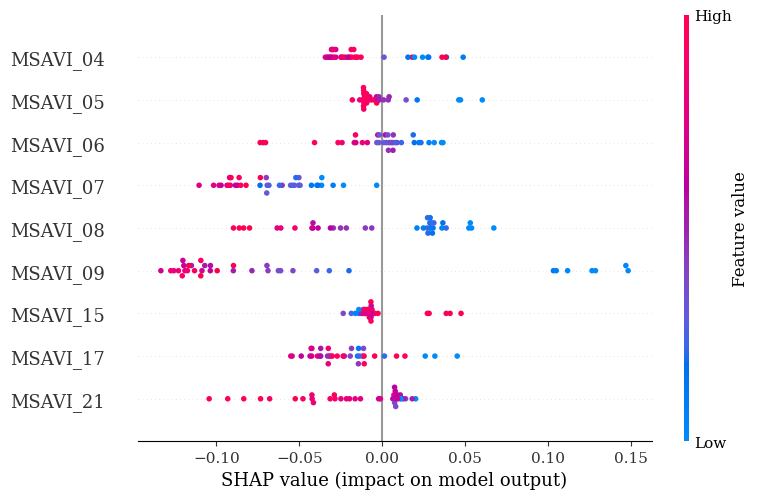

In [ ]:
sample_rest_cotton = sample_rest[(sample_rest["index"] == 0) & (sample_rest["Crop"] == "cotton") & (sample_rest['Salinity'] < 3.0) & (sample_rest['Salinity'] > 1.0)]
sample_rest_X, sample_rest_y = sample_rest_cotton[feat_labels].iloc[:, :-1], sample_rest_cotton[feat_labels].iloc[:, -1]
have_x = sample_rest_X
explainer = shap.TreeExplainer(regr4)
shap_values = explainer.shap_values(have_x)
shap_obj = explainer(have_x)
shap_values2 = copy.deepcopy(shap_obj)
shap_values2.values = shap_obj.values[:,:,1]
shap_values2.base_values = shap_obj.base_values[:,1]
shap.initjs()
mpl.rc('font', family='serif')
shap.summary_plot(shap_values=shap_values2.values,
                  features=have_x,
                  sort=False,
                  show=False)
# plt.savefig('1.tif',dpi=330,format='tif',bbox_inches='tight')
# files.download('1.tif')

In [ ]:
sample_rest_cotton

C1  C2  C3  C4    Crop Irrigate         Lat         Lon  MSAVI_00  \
4     0   0   0   0  cotton       Di  41.4825293  83.3211826 -1.085484   
5     0   0   0   0  cotton       Di  41.5066176  82.7884316 -1.364182   
43    0   0   0   0  cotton      Man  41.6604687  82.9482123 -1.012600   
44    0   0   0   0  cotton      Man  41.3183664  83.1386771 -1.209754   
45    0   0   0   0  cotton      Man  41.3201627  83.1121543 -1.182500   
46    0   0   0   0  cotton      Man  41.3426368  83.0501667 -1.129576   
47    0   0   0   0  cotton      Man  41.6134142  82.8729448 -1.245844   
48    0   0   0   0  cotton      Man  41.6148174  82.8439873 -1.170545   
49    0   0   0   0  cotton      Man  41.4861097  82.7524794 -1.167792   
50    0   0   0   0  cotton      Man   41.528163  82.9055255 -0.999068   
52    0   0   0   0  cotton      Man  41.2966298  83.1988461 -1.150096   
75    0   0   0   0  cotton       Di    41.11667    82.83889 -1.154786   
76    0   0   0   0  cotton       Di     41.3036    82.78815 -1.205077   
77    0   0   0   0  cotton       Di    41.30825    82.54795 -1.219488   
78    0   0   0   0  cotton      Gou     41.1818    82.87178 -1.137598   
79    0   0   0   0  cotton      Gou    41.16667       82.84 -1.204449   
89    0   0   0   0  cotton       Di       41.57   82.589722 -1.117881   
90    0   0   0   0  cotton       Di  41.4097139  82.5677915 -1.067506   
91    0   0   0   0  cotton       Di  41.4601039  82.5717903 -1.305894   
92    0   0   0   0  cotton       Di  41.4484507  82.3907168 -1.059289   
93    0   0   0   0  cotton       Di  41.5063825  82.4470839 -1.168397   
94    0   0   0   0  cotton       Di   41.572778   82.543889 -1.071911   
95    0   0   0   0  cotton       Di  41.6132558  82.6604584 -1.113003   
96    0   0   0   0  cotton       Di  41.6115836  82.6289364 -0.988764   
97    0   0   0   0  cotton       Di   41.615833   82.578889 -1.065332   
98    0   0   0   0  cotton       Di  41.4151043  82.5040156 -1.118761   
99    0   0   0   0  cotton       Di  41.4860437  82.5395873 -0.955182   
100   0   0   0   0  cotton       Di  41.6164497  82.4824185 -1.045235   
101   0   0   0   0  cotton       Di  41.5950051  82.5104242 -0.997602   
102   0   0   0   0  cotton       Di  41.3689702  82.5666161 -1.161747   
103   0   0   0   0  cotton       Di  41.4353587  82.5693981 -1.072546   
104   0   0   0   0  cotton       Di  41.4407651  82.5035863 -1.134320   
105   0   0   0   0  cotton       Di  41.5276557  82.3766172 -1.145407   
106   0   0   0   0  cotton       Di  41.5501058  82.5093991 -1.258034   
107   0   0   0   0  cotton       Di  41.5724052  82.4818141 -1.245394   
108   0   0   0   0  cotton       Di  41.5491005  82.4350826 -1.286079   
109   0   0   0   0  cotton       Di  41.6399331  82.6665995 -1.034218   

     MSAVI_01  ...  NDVI_max_16  NDVI_max_17  NDVI_max_18  NDVI_max_19  \
4   -1.212754  ...    -0.346883    -0.389374    -0.650520    -0.701773   
5   -1.389558  ...    -0.088299    -0.301608    -0.621368    -0.676751   
43  -1.047605  ...    -0.041475    -0.344922    -0.669101    -0.741217   
44  -1.264599  ...    -0.541687    -0.496260    -0.881203    -0.834995   
45  -1.169991  ...    -0.268509    -0.550789    -0.805163    -0.847365   
46  -1.100364  ...    -0.072293    -0.277254    -0.674490    -0.713595   
47  -1.285453  ...    -0.259593    -0.475959    -0.896472    -0.739406   
48  -1.257754  ...    -0.226132    -0.282207    -0.778120    -0.705701   
49  -1.327984  ...    -0.111469    -0.294429    -0.622653    -0.833108   
50  -1.119522  ...    -0.301749    -0.383000    -0.632581    -0.809764   
52  -1.221238  ...    -0.294517    -0.433888    -0.877041    -0.866122   
75  -1.175439  ...    -0.140914    -0.260854    -0.314022    -0.661005   
76  -1.153667  ...    -0.263229    -0.488222    -0.700532    -0.746053   
77  -1.303655  ...    -0.503132    -0.491755    -0.628286    -0.663916   
78  -1.705654  ...    -0.305553    -0.877698    -1.026119    -0.741620   
79  -1.3

In [ ]:
# label = NDVIImage.bandNames().getInfo()
label = ['NDVI_max_04', 'NDVI_max_05', 'NDVI_max_06', 'NDVI_max_07', 'NDVI_max_08', 'NDVI_max_09', 'NDVI_max_15', 'NDVI_max_17', 'NDVI_max_21']

In [ ]:
from sklearn.cluster import KMeans
import joblib
import numpy
import time
import matplotlib.pyplot as plt
from google.colab import files

sample_rest_X = sample_rest_cotton[label]
estimator = KMeans(n_clusters=4)#构造聚类器
estimator.fit(sample_rest_X)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和

result = estimator.fit_predict(sample_rest_X)

print("Predicting result: ", result)

Predicting result:  [2 2 2 2 2 2 2 2 2 2 1 0 1 1 0 0 1 2 3 1 1 1 3 2 1 1 1 1 2 2 1 1 3 1 3 3 3]


In [ ]:
sample_rest_cotton["class"] = result
sample_rest_cotton

C1  C2  C3  C4    Crop Irrigate         Lat         Lon  MSAVI_00  \
4     0   0   0   0  cotton       Di  41.4825293  83.3211826 -1.085484   
5     0   0   0   0  cotton       Di  41.5066176  82.7884316 -1.364182   
43    0   0   0   0  cotton      Man  41.6604687  82.9482123 -1.012600   
44    0   0   0   0  cotton      Man  41.3183664  83.1386771 -1.209754   
45    0   0   0   0  cotton      Man  41.3201627  83.1121543 -1.182500   
46    0   0   0   0  cotton      Man  41.3426368  83.0501667 -1.129576   
47    0   0   0   0  cotton      Man  41.6134142  82.8729448 -1.245844   
48    0   0   0   0  cotton      Man  41.6148174  82.8439873 -1.170545   
49    0   0   0   0  cotton      Man  41.4861097  82.7524794 -1.167792   
50    0   0   0   0  cotton      Man   41.528163  82.9055255 -0.999068   
52    0   0   0   0  cotton      Man  41.2966298  83.1988461 -1.150096   
75    0   0   0   0  cotton       Di    41.11667    82.83889 -1.154786   
76    0   0   0   0  cotton       Di     41.3036    82.78815 -1.205077   
77    0   0   0   0  cotton       Di    41.30825    82.54795 -1.219488   
78    0   0   0   0  cotton      Gou     41.1818    82.87178 -1.137598   
79    0   0   0   0  cotton      Gou    41.16667       82.84 -1.204449   
89    0   0   0   0  cotton       Di       41.57   82.589722 -1.117881   
90    0   0   0   0  cotton       Di  41.4097139  82.5677915 -1.067506   
91    0   0   0   0  cotton       Di  41.4601039  82.5717903 -1.305894   
92    0   0   0   0  cotton       Di  41.4484507  82.3907168 -1.059289   
93    0   0   0   0  cotton       Di  41.5063825  82.4470839 -1.168397   
94    0   0   0   0  cotton       Di   41.572778   82.543889 -1.071911   
95    0   0   0   0  cotton       Di  41.6132558  82.6604584 -1.113003   
96    0   0   0   0  cotton       Di  41.6115836  82.6289364 -0.988764   
97    0   0   0   0  cotton       Di   41.615833   82.578889 -1.065332   
98    0   0   0   0  cotton       Di  41.4151043  82.5040156 -1.118761   
99    0   0   0   0  cotton       Di  41.4860437  82.5395873 -0.955182   
100   0   0   0   0  cotton       Di  41.6164497  82.4824185 -1.045235   
101   0   0   0   0  cotton       Di  41.5950051  82.5104242 -0.997602   
102   0   0   0   0  cotton       Di  41.3689702  82.5666161 -1.161747   
103   0   0   0   0  cotton       Di  41.4353587  82.5693981 -1.072546   
104   0   0   0   0  cotton       Di  41.4407651  82.5035863 -1.134320   
105   0   0   0   0  cotton       Di  41.5276557  82.3766172 -1.145407   
106   0   0   0   0  cotton       Di  41.5501058  82.5093991 -1.258034   
107   0   0   0   0  cotton       Di  41.5724052  82.4818141 -1.245394   
108   0   0   0   0  cotton       Di  41.5491005  82.4350826 -1.286079   
109   0   0   0   0  cotton       Di  41.6399331  82.6665995 -1.034218   

     MSAVI_01  ...  NDVI_max_17  NDVI_max_18  NDVI_max_19  NDVI_max_20  \
4   -1.212754  ...    -0.389374    -0.650520    -0.701773    -0.883255   
5   -1.389558  ...    -0.301608    -0.621368    -0.676751    -0.772517   
43  -1.047605  ...    -0.344922    -0.669101    -0.741217    -0.835812   
44  -1.264599  ...    -0.496260    -0.881203    -0.834995    -1.036403   
45  -1.169991  ...    -0.550789    -0.805163    -0.847365    -0.928789   
46  -1.100364  ...    -0.277254    -0.674490    -0.713595    -0.813304   
47  -1.285453  ...    -0.475959    -0.896472    -0.739406    -0.869752   
48  -1.257754  ...    -0.282207    -0.778120    -0.705701    -0.860454   
49  -1.327984  ...    -0.294429    -0.622653    -0.833108    -0.818656   
50  -1.119522  ...    -0.383000    -0.632581    -0.809764    -0.789416   
52  -1.221238  ...    -0.433888    -0.877041    -0.866122    -1.066153   
75  -1.175439  ...    -0.260854    -0.314022    -0.661005    -0.921097   
76  -1.153667  ...    -0.488222    -0.700532    -0.746053    -0.833657   
77  -1.303655  ...    -0.491755    -0.628286    -0.663916    -0.854949   
78  -1.705654  ...    -0.877698    -1.026119    -0.741620    -0.738150   
79  -1.3

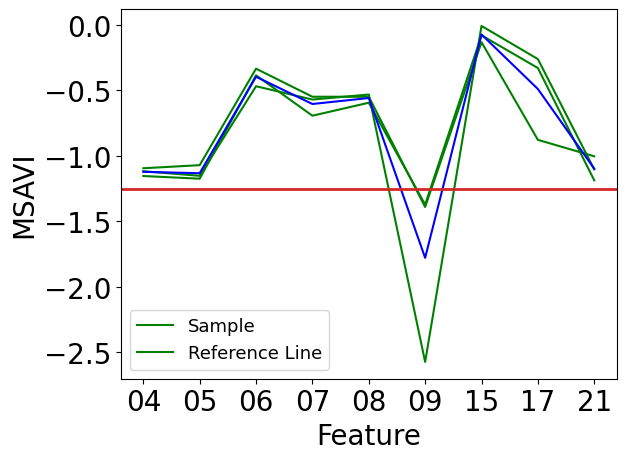

In [ ]:
class_0 = sample_rest_cotton[(sample_rest_cotton["class"] == 0)]
label = ['NDVI_max_04', 'NDVI_max_05', 'NDVI_max_06', 'NDVI_max_07', 'NDVI_max_08', 'NDVI_max_09', 'NDVI_max_15', 'NDVI_max_17', 'NDVI_max_21']
y = class_0[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
for i in range(len(y)):
  l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[2], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
plt.show()
# plt.savefig('1.tif',dpi=330,format='tif',bbox_inches='tight')
# files.download('1.tif')

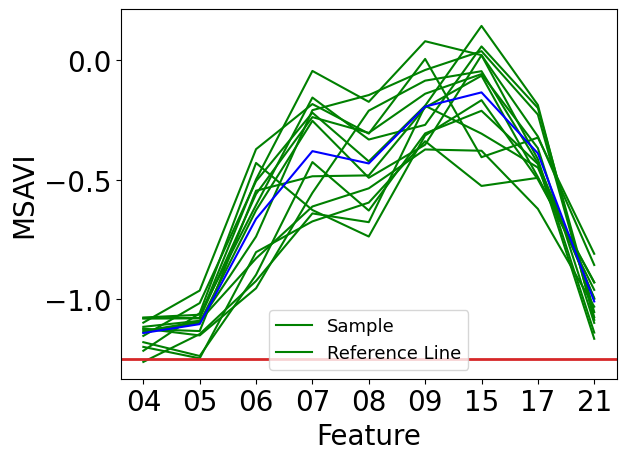

In [ ]:
class_1 = sample_rest_cotton[(sample_rest_cotton["class"] == 1)]
label = ['NDVI_max_04', 'NDVI_max_05', 'NDVI_max_06', 'NDVI_max_07', 'NDVI_max_08', 'NDVI_max_09', 'NDVI_max_15', 'NDVI_max_17', 'NDVI_max_21']
y = class_1[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
for i in range(len(y)):
  l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[0], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
# ax.legend(handles=[l1, l2], labels=['corn sample', 'unknown crop'], loc='best', prop={'size':13})
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
plt.show()
# plt.savefig('2.tif',dpi=330,format='tif',bbox_inches='tight')
# files.download('2.tif')

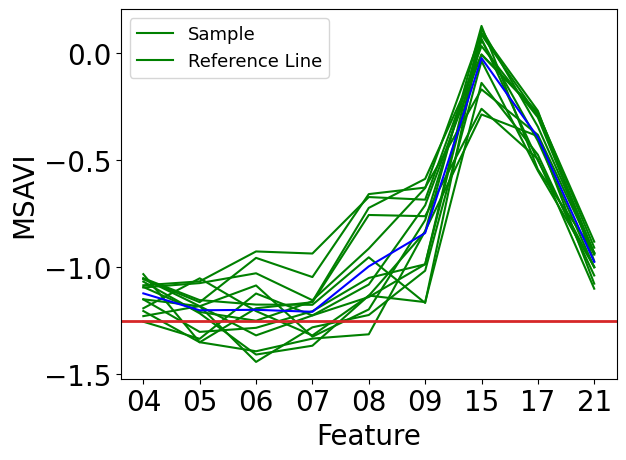

In [ ]:
class_2 = sample_rest_cotton[(sample_rest_cotton["class"] == 2)]
y = class_2[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
for i in range(len(y)):
  l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[1], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
# ax.legend(handles=[l1, l2], labels=['corn sample', 'unknown crop'], loc='best', prop={'size':13})
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
plt.show()
# plt.savefig('3.tif',dpi=330,format='tif',bbox_inches='tight')
# files.download('3.tif')

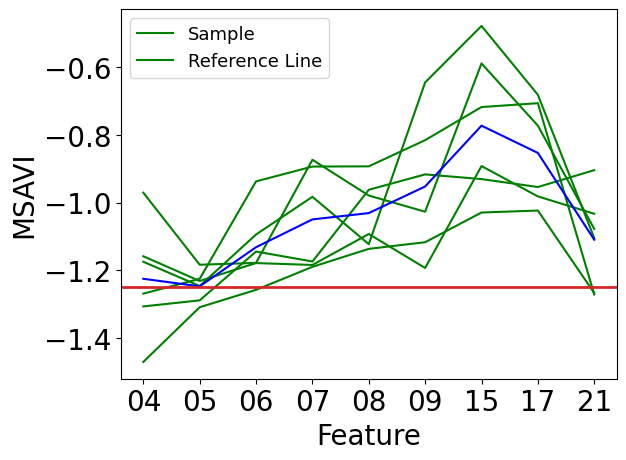

In [ ]:
class_3 = sample_rest_cotton[(sample_rest_cotton["class"] == 3)]
y = class_3[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
for i in range(len(y)):
  l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[3], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
# ax.legend(handles=[l1, l2], labels=['corn sample', 'unknown crop'], loc='best', prop={'size':13})
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
plt.show()
# plt.savefig('2.tif',dpi=330,format='tif',bbox_inches='tight')
# files.download('2.tif')

In [ ]:
Class = pd.concat([class_1, class_2])
sample_rest_X, sample_rest_y = Class[feat_labels].iloc[:, :-1], Class[feat_labels].iloc[:, -1]
have_x = sample_rest_X
explainer = shap.TreeExplainer(regr4)
shap_values = explainer.shap_values(have_x)
shap_obj = explainer(have_x)
shap_values2 = copy.deepcopy(shap_obj)
shap_values2.values = shap_obj.values[:,:,1]
shap_values2.base_values = shap_obj.base_values[:,1]
shap.initjs()
mpl.rc('font', family='serif')
shap.summary_plot(shap_values=shap_values2.values,
                  features=have_x,
                  sort=False,
                  show=False)
plt.savefig('1.tif',dpi=330,format='tif',bbox_inches='tight')
files.download('1.tif')

NameError: ignored

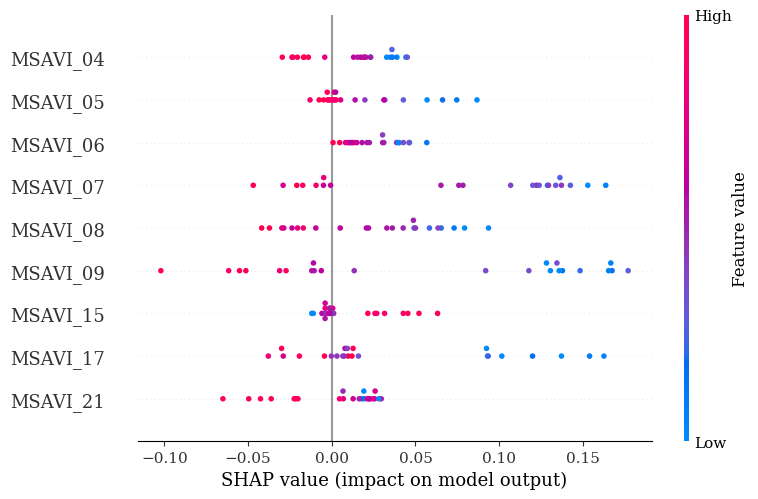

In [ ]:
sample_delete_cotton = sample_delete[(sample_delete["index"] == 0) & (sample_delete["Crop"] == "cotton") & (sample_delete['Salinity'] < 3.0) & (sample_delete['Salinity'] > 1.0)]
sample_delete_X, sample_delete_y = sample_delete_cotton[feat_labels].iloc[:, :-1], sample_delete_cotton[feat_labels].iloc[:, -1]
have_x = sample_delete_X
explainer = shap.TreeExplainer(regr4)
shap_values = explainer.shap_values(have_x)
shap_obj = explainer(have_x)
shap_values2 = copy.deepcopy(shap_obj)
shap_values2.values = shap_obj.values[:,:,1]
shap_values2.base_values = shap_obj.base_values[:,1]
shap.initjs()
mpl.rc('font', family='serif')
shap.summary_plot(shap_values=shap_values2.values,
                  features=have_x,
                  sort=False,
                  show=False)
# plt.savefig('2.tif',dpi=330,format='tif',bbox_inches='tight')
# files.download('2.tif')

In [ ]:
sample_delete_cotton

C1  C2  C3  C4    Crop Irrigate         Lat         Lon  MSAVI_00  \
26   0   0   1   1  cotton       Di  41.5046522  82.8750589 -1.140043   
29   0   0   1   1  cotton       Di    41.30134    82.64251 -1.260737   
30   0   0   1   1  cotton       Di    41.25553    82.90713 -1.274103   
31   0   0   1   1  cotton      Man    41.22935    82.91237 -1.112163   
32   0   0   1   1  cotton       Di  41.5061806   82.362113 -1.189854   
33   0   0   1   1  cotton       Di  41.5513256  82.3911537 -1.316505   
34   0   0   1   1  cotton       Di  41.4964638  82.3291163 -0.994991   
35   0   0   1   1  cotton       Di  41.2781664  82.3864261 -1.487725   
36   0   1   1   1  cotton       Di   41.524122  83.0860663 -1.076488   
38   0   1   1   1  cotton      Man  41.2261595   83.285045 -0.964131   
39   0   1   1   1  cotton      Man  41.6379312  83.0843366 -1.143117   
40   0   1   1   1  cotton       Di    41.34079    82.79369 -1.449227   
41   0   1   1   1  cotton       Di    41.37174    82.73357 -1.084426   
42   0   1   1   1  cotton       Di    41.28324    82.65993 -1.302937   
43   0   1   1   1  cotton      Gou    41.23596    82.68856 -1.364318   
44   1   1   0   1  cotton       Di  41.4851281  82.7224051 -1.248344   
45   1   1   1   1  cotton       Di  41.5738418  82.7910512 -1.230522   
46   1   1   1   1  cotton       Di     41.2648    82.57492 -1.260570   
48   1   1   1   1  cotton      Gou    41.40603    82.91135 -1.411782   
49   1   1   1   1  cotton      Man    41.36947     82.7547 -1.773741   
50   1   1   1   1  cotton      Man    41.20961    82.93754 -1.237229   
52   1   1   1   1  cotton       Di  41.4147474  82.2535484 -1.434643   
53   1   1   1   1  cotton       Di  41.4605809  82.3225101 -1.035612   

    MSAVI_01  ...  NDVI_max_16  NDVI_max_17  NDVI_max_18  NDVI_max_19  \
26 -1.238235  ...    -0.272435    -0.524160    -0.872519    -0.830905   
29 -1.260686  ...    -0.367260    -0.412898    -0.812349    -0.746071   
30 -1.255799  ...    -0.303024    -0.379582    -0.909409    -0.847734   
31 -1.320647  ...    -0.060035    -0.338563    -0.954006    -0.875718   
32 -1.682703  ...    -0.296136    -0.506398    -0.789743    -0.749120   
33 -1.481138  ...    -0.058563    -0.306903    -0.711234    -0.731531   
34 -1.279960  ...    -0.159806    -0.236285    -0.736942    -0.784000   
35 -1.661233  ...    -0.144997    -0.493190    -0.911009    -0.875139   
36 -1.211177  ...    -0.202087    -0.501805    -0.844078    -0.779290   
38 -1.350308  ...    -0.194387    -0.301062    -0.686962    -0.701863   
39 -1.316102  ...    -0.584956    -0.413235    -0.786525    -0.921406   
40 -1.350121  ...    -1.134927    -0.979486    -1.113631    -1.038592   
41 -1.362188  ...    -0.402602    -0.669809    -1.042287    -0.858738   
42 -1.257264  ...    -0.130610    -0.442705    -0.732226    -0.701894   
43 -1.391174  ...    -0.128559    -0.291757    -0.542414    -0.589782   
44 -1.391841  ...    -0.585281    -0.767961    -0.714962    -1.094982   
45 -1.235100  ...    -0.072995    -0.386514    -0.927631    -0.754268   
46 -1.287197  ...    -0.606956    -0.438656    -0.561074    -0.673896   
48 -1.439691  ...    -0.300423    -0.501502    -0.855693    -0.828248   
49 -1.466698  ...    -0.277973    -0.393722    -0.745165    -0.743888   
50 -1.620893  ...    -0.135632    -0.932911    -1.049592    -0.982037   
52 -1.910115  ...    -0.407274    -0.719467    -0.874626    -0.849220   
53 -1.450818  ...    -0.248528    -0.350155    -0.792731    -0.738435   

    NDVI_max_20  NDVI_max_21                Number  Salinity  index  pred  
26    -0.873810    -0.939687   842007C20180926A058      1.70      0     0  
29    -1.052970    -1.137475   842200C20181104A020      1.38      0     0  
30    -0.907184    -0.940560   842200C20181104C090      1.96      0     0  
31    -1.038106    -1.150037   842200C20181104B046      1.98      0     0  
32    -0.904683    -1.174412   842100C20180910A021      1.10      0     0  
33    -0.798696    -1.025727   842100C2018

In [ ]:
from sklearn.cluster import KMeans
import joblib
import numpy
import time
import matplotlib.pyplot as plt
from google.colab import files

sample_delete_X = sample_delete_cotton[label]
estimator = KMeans(n_clusters=3)#构造聚类器
estimator.fit(sample_delete_X)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和

result = estimator.fit_predict(sample_delete_X)

print("Predicting result: ", result)

Predicting result:  [2 2 2 2 2 2 2 2 2 2 1 1 2 0 2 1 2 1 2 2 0 2 2]


In [ ]:
sample_delete_X["class"] = result
sample_delete_X

NDVI_max_04  NDVI_max_05  NDVI_max_06  NDVI_max_07  NDVI_max_08  \
26    -1.114383    -1.244158    -1.380185    -1.337181    -1.170453   
29    -1.221903    -1.300750    -1.201065    -1.356462    -1.268214   
30    -1.128943    -1.154927    -1.220449    -1.470944    -1.354900   
31    -1.079428    -1.119871    -1.246123    -1.270171    -0.947674   
32    -1.154464    -1.198418    -1.251997    -1.371464    -1.218670   
33    -1.269848    -1.223503    -1.275704    -1.398480    -1.330988   
34    -1.193275    -1.212029    -1.241728    -1.450790    -1.413388   
35    -1.240430    -1.306721    -1.291663    -1.713865    -1.670956   
36    -1.002070    -1.313431    -1.469660    -1.563436    -1.547428   
38    -1.248913    -1.309165    -1.288231    -1.427320    -1.237299   
39    -1.215165    -1.402367    -0.922179    -1.528843    -1.459343   
40    -1.467219    -1.418074    -1.305944    -1.402738    -1.336213   
41    -1.292558    -1.277445    -1.354504    -1.426429    -1.298408   
42    -1.202176    -1.281555    -0.800780    -0.877848    -0.681357   
43    -1.214135    -1.292439    -1.268590    -1.093905    -1.070858   
44    -1.147560    -1.198259    -1.098703    -1.277450    -1.064561   
45    -1.165764    -1.308115    -1.308617    -1.441963    -1.367298   
46    -1.143739    -1.294256    -0.897522    -0.803361    -1.031905   
48    -1.091965    -1.395557    -1.341133    -1.287266    -1.117479   
49    -1.226033    -1.271334    -1.206517    -1.377546    -1.243938   
50    -1.288675    -1.275523    -0.931195    -0.965715    -0.697076   
52    -1.309169    -1.362393    -1.552021    -1.516055    -1.585133   
53    -1.034593    -1.128089    -1.636065    -1.576493    -1.388303   

    NDVI_max_09  NDVI_max_15  NDVI_max_17  NDVI_max_21  class  
26    -1.246020    -0.017181    -0.524160    -0.939687      2  
29    -1.305612    -0.249308    -0.412898    -1.137475      2  
30    -1.145484    -0.129833    -0.379582    -0.940560      2  
31    -0.790174    -0.143760    -0.338563    -1.150037      2  
32    -0.720499    -0.050941    -0.506398    -1.174412      2  
33    -0.972463     0.130862    -0.306903    -1.025727      2  
34    -1.055863    -0.047219    -0.236285    -1.036055      2  
35    -1.108697     0.054728    -0.493190    -0.987697      2  
36    -1.322555     0.054934    -0.501805    -0.966363      2  
38    -0.906856    -0.210472    -0.301062    -0.914107      2  
39    -1.393038    -0.501279    -0.413235    -1.353074      1  
40    -1.282789    -0.886265    -0.979486    -1.277694      1  
41    -1.184333    -0.159352    -0.669809    -1.394311      2  
42    -0.563399     0.045858    -0.442705    -1.178892      0  
43    -0.898928    -0.025338    -0.291757    -1.026697      2  
44    -0.985888    -0.608099    -0.767961    -1.155973      1  
45    -1.201751     0.064884    -0.386514    -1.001160      2  
46    -0.870380    -0.639987    -0.438656    -1.170999      1  
48    -0.898595    -0.055563    -0.501502    -1.231811      2  
49    -1.356277    -0.066514    -0.393722    -1.234703      2  
50    -0.312950     0.041041    -0.932911    -1.344718      0  
52    -1.020039    -0.155069    -0.719467    -1.176684      2  
53    -0.625355     0.004465    -0.350155    -0.966259      2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

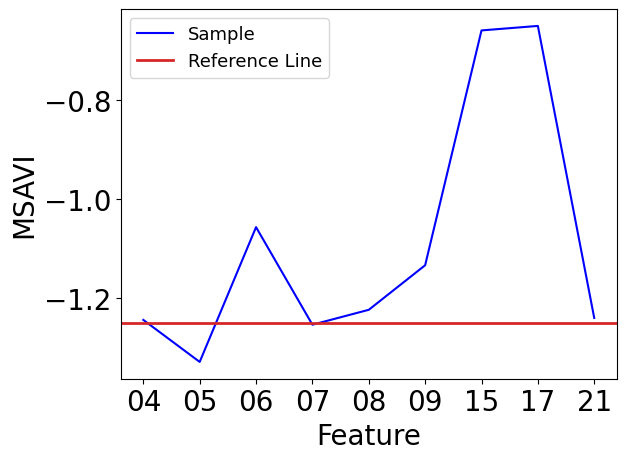

In [ ]:
class_0 = sample_delete_X[(sample_delete_X["class"] == 0)]
y = class_0[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
# for i in range(len(y)):
#   l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[0], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
# ax.legend(handles=[l1, l2], labels=['corn sample', 'unknown crop'], loc='best', prop={'size':13})
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
# plt.show()
plt.savefig('3.tif',dpi=330,format='tif',bbox_inches='tight')
files.download('3.tif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

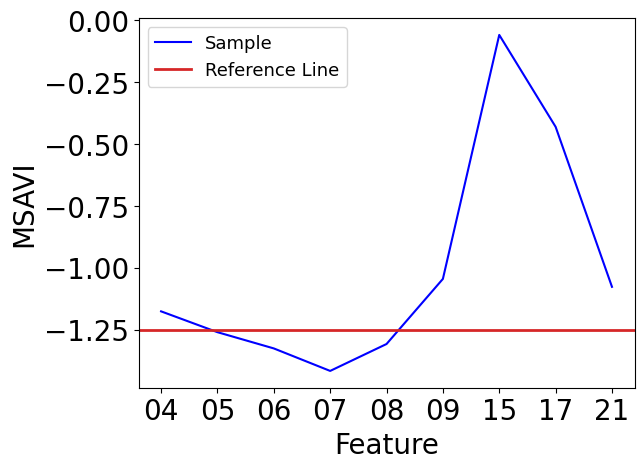

In [ ]:
class_1 = sample_delete_X[(sample_delete_X["class"] == 1)]
y = class_1[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
# for i in range(len(y)):
#   l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[1], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
# ax.legend(handles=[l1, l2], labels=['corn sample', 'unknown crop'], loc='best', prop={'size':13})
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
# plt.show()
plt.savefig('3.tif',dpi=330,format='tif',bbox_inches='tight')
files.download('3.tif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

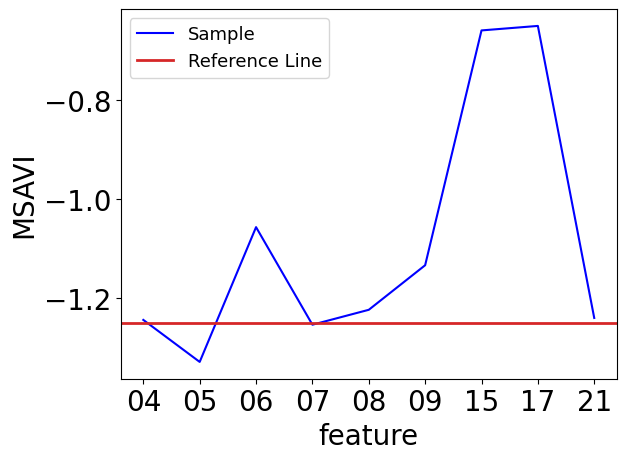

In [ ]:
class_2 = sample_delete_X[(sample_delete_X["class"] == 2)]
y = class_2[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
# for i in range(len(y)):
#   l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[2], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
# ax.legend(handles=[l1, l2], labels=['corn sample', 'unknown crop'], loc='best', prop={'size':13})
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
# plt.show()
plt.savefig('5.tif',dpi=330,format='tif',bbox_inches='tight')
files.download('5.tif')

#### 棉花有盐碱样本

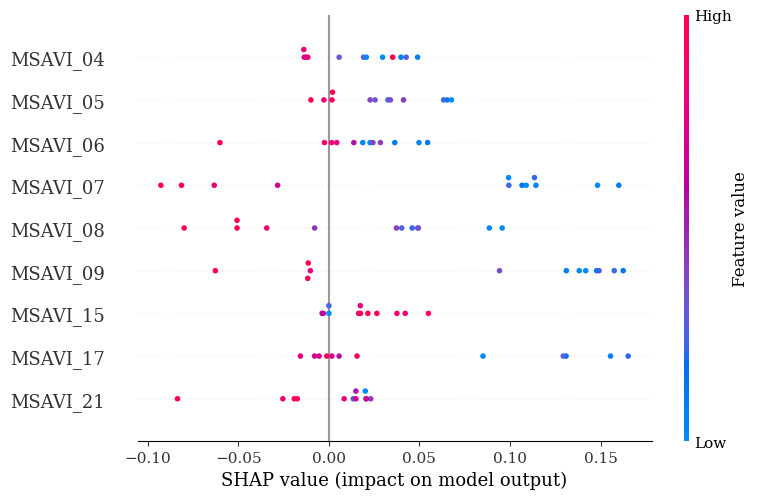

In [ ]:
sample_rest_cotton = sample_rest[(sample_rest["index"] == 1) & (sample_rest["Crop"] == "cotton") & (sample_rest['Salinity'] < 3.0) & (sample_rest['Salinity'] > 1.0)]
sample_rest_X, sample_rest_y = sample_rest_cotton[feat_labels].iloc[:, :-1], sample_rest_cotton[feat_labels].iloc[:, -1]
have_x = sample_rest_X
explainer = shap.TreeExplainer(regr4)
shap_values = explainer.shap_values(have_x)
shap_obj = explainer(have_x)
shap_values2 = copy.deepcopy(shap_obj)
shap_values2.values = shap_obj.values[:,:,1]
shap_values2.base_values = shap_obj.base_values[:,1]
shap.initjs()
mpl.rc('font', family='serif')
shap.summary_plot(shap_values=shap_values2.values,
                  features=have_x,
                  sort=False,
                  show=False)
# plt.savefig('3.tif',dpi=330,format='tif',bbox_inches='tight')
# files.download('3.tif')

In [ ]:
sample_rest_cotton

C1  C2  C3  C4    Crop Irrigate         Lat         Lon  MSAVI_00  \
201   1   1   1   1  cotton       Di  41.5264955  82.9614738 -1.236902   
202   1   1   1   1  cotton       Di  41.5238428  83.1113789 -1.430602   
205   1   1   1   0  cotton       Di    41.27798    82.76242 -1.091555   
206   1   1   1   1  cotton       Di    41.21212    82.63579 -1.715289   
207   1   1   1   1  cotton       Di    41.21142    82.87536 -1.594838   
208   1   1   1   1  cotton      Man    41.43626     82.7285 -1.168811   
209   1   1   1   1  cotton       Di  41.3968044   82.296833 -1.093700   
210   1   1   1   1  cotton       Di  41.3691004  82.3252538 -1.065594   
253   1   1   1   1  cotton       Di    41.43627    82.85033 -1.761397   
254   1   1   1   1  cotton       Di    41.25448    82.84287 -1.398035   
280   1   1   1   1  cotton      Gou     41.2597     82.7642 -1.123112   
282   1   1   1   1  cotton      Man    41.34526    82.69995 -1.064343   

     MSAVI_01  ...  NDVI_max_16  NDVI_max_17  NDVI_max_18  NDVI_max_19  \
201 -1.301202  ...    -0.343779    -0.612380    -0.876578    -0.854633   
202 -1.385031  ...    -0.191757    -0.261973    -0.794567    -0.799017   
205 -1.298478  ...    -0.228712    -0.149082    -0.301056    -0.454247   
206 -1.279776  ...    -0.288471    -0.421718    -0.823625    -0.804797   
207 -1.509923  ...    -0.087796    -0.278514    -0.742927    -0.785398   
208 -1.241086  ...    -0.517141    -0.347011    -0.731950    -0.714349   
209 -1.290354  ...    -0.233411    -0.437334    -0.740702    -0.709582   
210 -1.169749  ...    -0.060695    -0.407433    -0.793398    -0.868184   
253 -1.749177  ...    -1.015474    -1.303403    -1.158772    -1.216228   
254 -1.649839  ...    -0.186611    -0.489371    -0.967899    -0.853350   
280 -1.294603  ...    -0.137159    -0.482292    -0.864925    -0.793016   
282 -1.173160  ...    -0.191961    -0.295356    -0.983675    -1.051155   

     NDVI_max_20  NDVI_max_21               Number  Salinity  index  pred  
201    -0.944639    -1.055827  842007C20180925A067      2.00      1     1  
202    -1.079103    -1.177602  842013C20181001A100      2.30      1     1  
205    -0.795840    -0.974321  842200C20181104D097      2.10      1     1  
206    -0.902924    -1.012496  842200C20181104B057      2.12      1     1  
207    -0.912319    -1.122321  842200C20181104C066      2.37      1     1  
208    -1.011875    -1.057253  842200C20181104B051      2.43      1     1  
209    -0.894149    -0.841570  842100C20180910A027      2.00      1     1  
210    -0.877026    -0.874025  842100C20180910A038      2.30      1     1  
253    -1.572857    -1.532274  842200C20181104A025      2.73      1     1  
254    -0.918243    -1.138210  842200C20181104B047      2.78      1     1  
280    -0.876242    -1.007781  842200C20181104C062      2.66      1     1  
282    -1.138406    -1.144228  842200C20181104D110      2.80      1     1  

[12 rows x 57 columns]

In [ ]:
from sklearn.cluster import KMeans
import joblib
import numpy
import time
import matplotlib.pyplot as plt
from google.colab import files

sample_rest_X = sample_rest_cotton[label]
estimator = KMeans(n_clusters=3)#构造聚类器
estimator.fit(sample_rest_X)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和

result = estimator.fit_predict(sample_rest_X)

print("Predicting result: ", result)

Predicting result:  [0 0 1 0 0 1 0 0 2 0 1 1]


In [ ]:
sample_rest_X["class"] = result
sample_rest_X

NDVI_max_04  NDVI_max_05  NDVI_max_06  NDVI_max_07  NDVI_max_08  \
201    -1.446790    -1.280454    -1.409891    -1.445476    -1.299425   
202    -1.147316    -1.339427    -1.280382    -1.459570    -1.422747   
205    -0.974063    -1.061217    -0.362146    -0.471160    -0.517947   
206    -1.209042    -1.116536    -1.225618    -1.384135    -1.279584   
207    -1.274593    -1.295084    -1.644200    -1.687498    -1.372189   
208    -1.072887    -1.134685    -0.551846    -0.414414    -0.614945   
209    -1.168795    -1.112687    -1.279237    -1.518215    -1.485314   
210    -1.210339    -1.059389    -1.131538    -1.579763    -1.578493   
253    -1.267568    -1.451241    -1.578125    -1.567748    -1.518031   
254    -1.076102    -1.104992    -1.618940    -1.614564    -1.563943   
280    -1.079201    -1.060730    -0.618429    -0.676677    -0.399709   
282    -1.152926    -1.267255    -1.034689    -0.499490    -0.437395   

     NDVI_max_09  NDVI_max_15  NDVI_max_17  NDVI_max_21  class  
201    -1.009139    -0.229090    -0.612380    -1.055827      0  
202    -1.411064     0.002411    -0.261973    -1.177602      0  
205    -0.313596    -0.134426    -0.149082    -0.974321      1  
206    -0.800906    -0.163667    -0.421718    -1.012496      0  
207    -1.857813     0.057595    -0.278514    -1.122321      0  
208    -0.967073    -0.447782    -0.347011    -1.057253      1  
209    -0.732984     0.077261    -0.437334    -0.841570      0  
210    -0.840420     0.161065    -0.407433    -0.874025      0  
253    -1.753610    -1.089581    -1.303403    -1.532274      2  
254    -1.538255    -0.045876    -0.489371    -1.138210      0  
280    -1.136990    -0.035722    -0.482292    -1.007781      1  
282    -0.147214     0.087202    -0.295356    -1.144228      1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

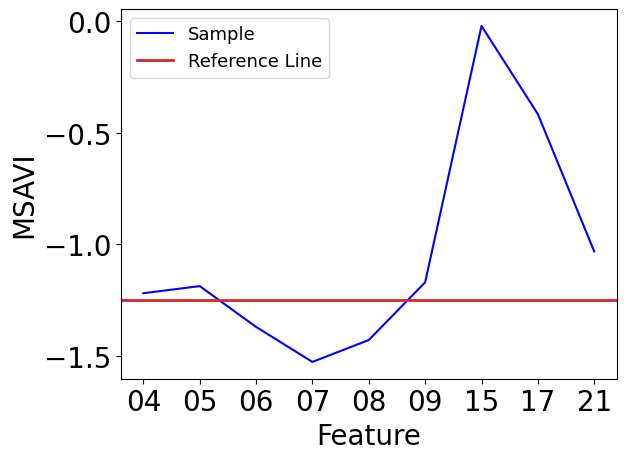

In [ ]:
class_0 = sample_rest_X[(sample_rest_X["class"] == 0)]
y = class_0[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
# for i in range(len(y)):
#   l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[0], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
# ax.legend(handles=[l1, l2], labels=['corn sample', 'unknown crop'], loc='best', prop={'size':13})
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
# plt.show()
plt.savefig('4.tif',dpi=330,format='tif',bbox_inches='tight')
files.download('4.tif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

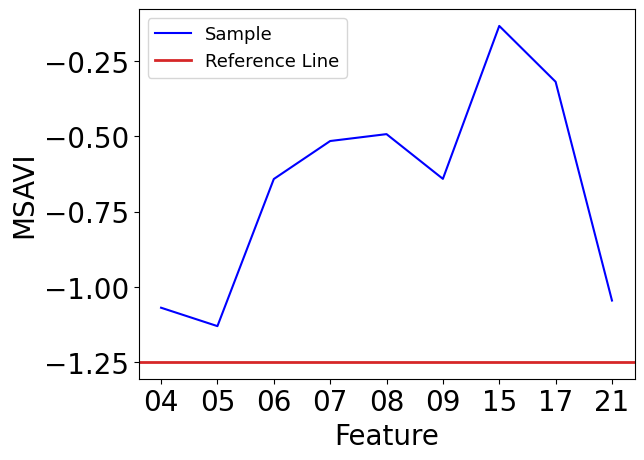

In [ ]:
class_1 = sample_rest_X[(sample_rest_X["class"] == 1)]
y = class_1[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
# for i in range(len(y)):
#   l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[1], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
# ax.legend(handles=[l1, l2], labels=['corn sample', 'unknown crop'], loc='best', prop={'size':13})
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
# plt.show()
plt.savefig('4.tif',dpi=330,format='tif',bbox_inches='tight')
files.download('4.tif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

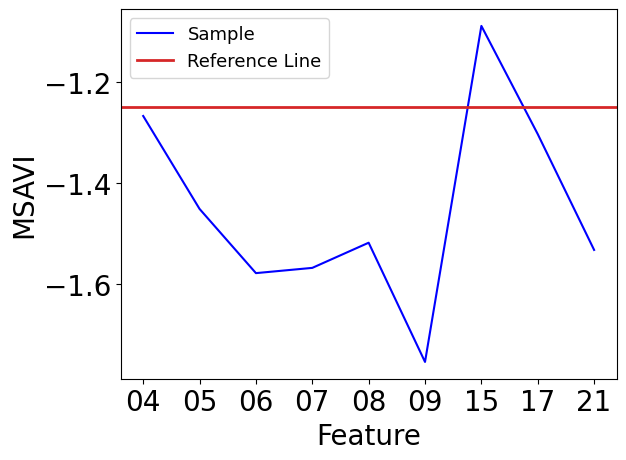

In [ ]:
class_2 = sample_rest_X[(sample_rest_X["class"] == 2)]
y = class_2[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
# for i in range(len(y)):
#   l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[2], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
# ax.legend(handles=[l1, l2], labels=['corn sample', 'unknown crop'], loc='best', prop={'size':13})
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
# plt.show()
plt.savefig('4.tif',dpi=330,format='tif',bbox_inches='tight')
files.download('4.tif')

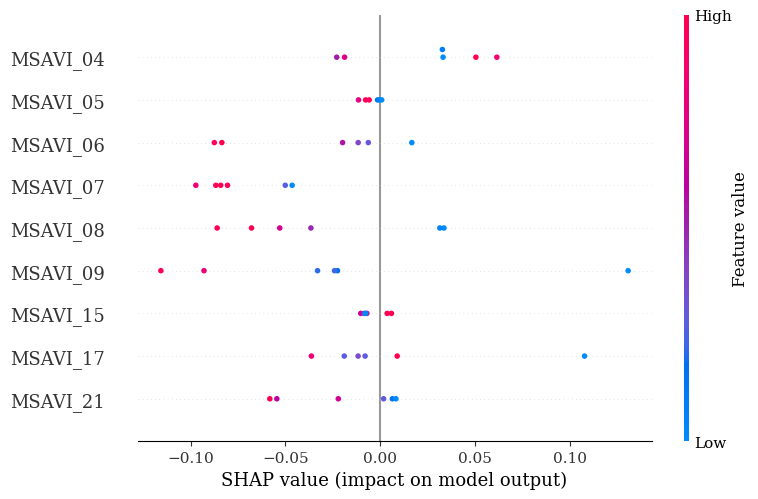

In [ ]:
sample_delete_cotton = sample_delete[(sample_delete["index"] == 1) & (sample_delete["Crop"] == "cotton")]
sample_delete_X, sample_delete_y = sample_delete_cotton[feat_labels].iloc[:, :-1], sample_delete_cotton[feat_labels].iloc[:, -1]
have_x = sample_delete_X
explainer = shap.TreeExplainer(regr4)
shap_values = explainer.shap_values(have_x)
shap_obj = explainer(have_x)
shap_values2 = copy.deepcopy(shap_obj)
shap_values2.values = shap_obj.values[:,:,1]
shap_values2.base_values = shap_obj.base_values[:,1]
shap.initjs()
mpl.rc('font', family='serif')
shap.summary_plot(shap_values=shap_values2.values,
                  features=have_x,
                  sort=False,
                  show=False)
# plt.savefig('4.tif',dpi=330,format='tif',bbox_inches='tight')
# files.download('4.tif')

In [ ]:
sample_delete_cotton

C1  C2  C3  C4    Crop Irrigate         Lat         Lon  MSAVI_00  \
1    0   0   0   0  cotton      Man     41.4192    82.90484 -1.236139   
2    0   1   0   0  cotton       Di  41.3969633   82.388352 -1.066540   
7    1   1   0   0  cotton       Di    41.39248    82.60658 -1.093024   
8    1   1   0   0  cotton       Di  41.4285195  82.4397247 -1.028611   
10   1   0   0   0  cotton      Gou    41.38776    82.97138 -1.100774   
25   1   1   0   0  cotton      Man  41.5488159  82.7246369 -1.061248   

    MSAVI_01  ...  NDVI_max_16  NDVI_max_17  NDVI_max_18  NDVI_max_19  \
1  -1.297459  ...    -0.204854    -0.627349    -0.715197    -0.724308   
2  -1.198219  ...    -0.273218    -0.255521    -0.307465    -0.508934   
7  -1.163195  ...    -0.270629    -0.559688    -0.748234    -0.886314   
8  -1.121792  ...    -0.143556    -0.511062    -0.695929    -0.912241   
10 -1.180975  ...    -0.261361    -0.313516    -0.702053    -0.780119   
25 -1.118999  ...    -0.186619    -0.332169    -0.649402    -0.715885   

    NDVI_max_20  NDVI_max_21               Number  Salinity  index  pred  
1     -0.921861    -1.087882  842200C20181104A009      2.59      1     1  
2     -0.869826    -1.015302  842100C20180910A046      2.40      1     1  
7     -0.905314    -0.995427  842200C20181104D104      2.43      1     1  
8     -0.922998    -1.035364  842100C20180910A043      2.00      1     1  
10    -0.896711    -1.033805  842200C20181104C065      2.02      1     1  
25    -0.779864    -0.916559  842008C20180916A028      2.50      1     1  

[6 rows x 57 columns]

In [ ]:
from sklearn.cluster import KMeans
import joblib
import numpy
import time
import matplotlib.pyplot as plt
from google.colab import files

sample_delete_X = sample_delete_cotton[label]
estimator = KMeans(n_clusters=2)#构造聚类器
estimator.fit(sample_delete_X)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和

result = estimator.fit_predict(sample_delete_X)

print("Predicting result: ", result)

Predicting result:  [1 1 1 1 1 0]


In [ ]:
sample_delete_X["class"] = result
sample_delete_X

NDVI_max_04  NDVI_max_05  NDVI_max_06  NDVI_max_07  NDVI_max_08  \
1     -1.125419    -1.237584    -0.553385    -0.511211    -0.342856   
2     -1.086197    -1.083918    -0.275041    -0.470595    -0.698558   
7     -1.153664    -1.186221    -0.724606    -0.586506    -0.603214   
8     -1.189793    -1.187857    -0.826570    -0.309098    -0.327846   
10    -1.117903    -1.140763    -0.512797    -0.461387    -0.364965   
25    -1.097553    -1.153902    -1.202608    -1.101005    -0.925953   

    NDVI_max_09  NDVI_max_15  NDVI_max_17  NDVI_max_21  class  
1     -0.155531     0.012127    -0.627349    -1.087882      1  
2     -0.430945    -0.315429    -0.255521    -1.015302      1  
7     -0.360019    -0.146295    -0.559688    -0.995427      1  
8     -0.078893    -0.056363    -0.511062    -1.035364      1  
10    -0.063774    -0.091852    -0.313516    -1.033805      1  
25    -0.691299     0.042195    -0.332169    -0.916559      0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

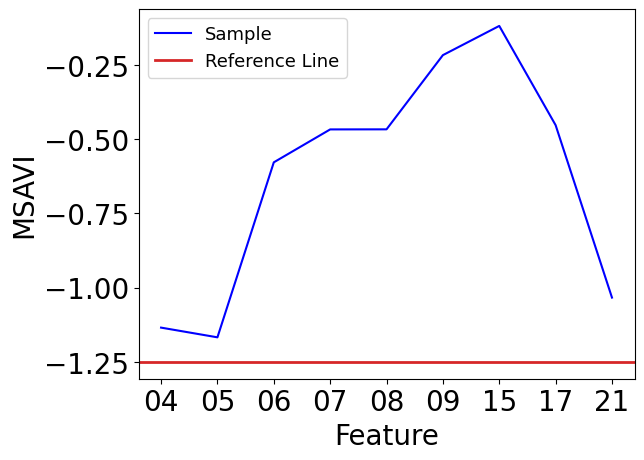

In [ ]:
class_0 = sample_delete_X[(sample_delete_X["class"] == 0)]
y = class_0[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
# for i in range(len(y)):
#   l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[0], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
# ax.legend(handles=[l1, l2], labels=['corn sample', 'unknown crop'], loc='best', prop={'size':13})
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
# plt.show()
plt.savefig('4.tif',dpi=330,format='tif',bbox_inches='tight')
files.download('4.tif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

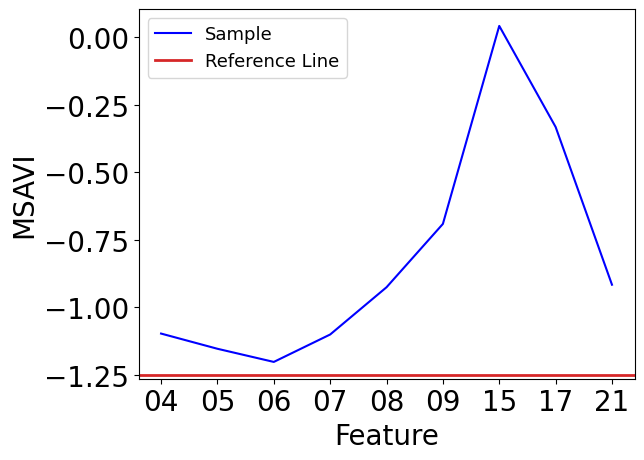

In [ ]:
class_1 = sample_delete_X[(sample_delete_X["class"] == 1)]
y = class_1[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
# for i in range(len(y)):
#   l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[1], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
# ax.legend(handles=[l1, l2], labels=['corn sample', 'unknown crop'], loc='best', prop={'size':13})
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
# plt.show()
plt.savefig('4.tif',dpi=330,format='tif',bbox_inches='tight')
files.download('4.tif')

#### 玉米无盐碱样本

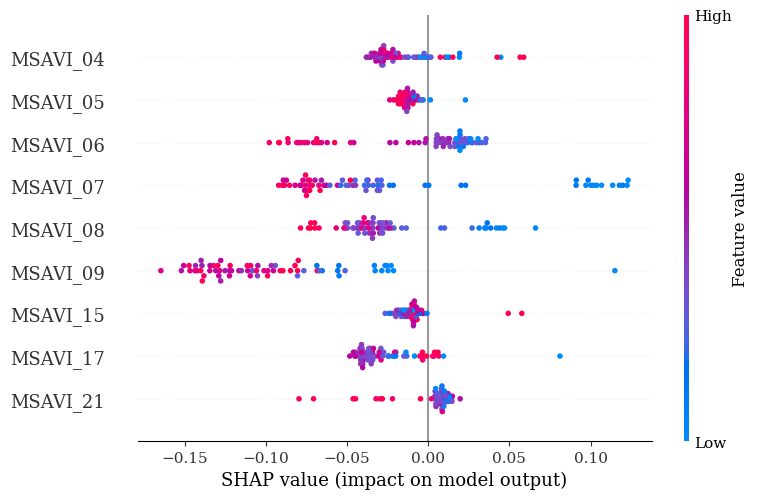

In [ ]:
sample_rest_cotton = sample_rest[(sample_rest["index"] == 0) & (sample_rest["Crop"] == "corn") & (sample_rest['Salinity'] < 3.0) & (sample_rest['Salinity'] > 1.0)]
sample_rest_X, sample_rest_y = sample_rest_cotton[feat_labels].iloc[:, :-1], sample_rest_cotton[feat_labels].iloc[:, -1]
have_x = sample_rest_X
explainer = shap.TreeExplainer(regr4)
shap_values = explainer.shap_values(have_x)
shap_obj = explainer(have_x)
shap_values2 = copy.deepcopy(shap_obj)
shap_values2.values = shap_obj.values[:,:,1]
shap_values2.base_values = shap_obj.base_values[:,1]
shap.initjs()
mpl.rc('font', family='serif')
shap.summary_plot(shap_values=shap_values2.values,
                  features=have_x,
                  sort=False,
                  show=False)
# plt.savefig('5.tif',dpi=330,format='tif',bbox_inches='tight')
# files.download('5.tif')

In [ ]:
sample_rest_cotton

C1  C2  C3  C4  Crop Irrigate         Lat         Lon  MSAVI_00  \
10    0   0   0   0  corn      Man  41.6784371  83.0306507 -1.157167   
11    0   0   0   0  corn      Man  41.6385306  83.0577255 -1.064977   
12    0   0   0   0  corn      Man  41.6145211  82.8210101 -1.091282   
13    0   0   0   0  corn      Man  41.6181731  82.7884471 -1.162693   
14    0   0   0   0  corn      Man   41.483953  82.8736315 -1.176074   
..   ..  ..  ..  ..   ...      ...         ...         ...       ...   
170   0   0   0   0  corn      Man   41.690488   81.850791 -1.290579   
171   0   0   0   0  corn      Man   41.669563   81.789832 -1.120042   
172   0   0   0   0  corn      Man   41.692047   81.876847 -0.936436   
173   0   0   0   0  corn      Man   41.703374   81.913933 -1.056683   
174   0   0   0   0  corn      Man   41.707868   81.965772 -1.244705   

     MSAVI_01  ...  NDVI_max_16  NDVI_max_17  NDVI_max_18  NDVI_max_19  \
10  -1.190019  ...    -1.094337    -0.914893    -0.823094    -0.833128   
11  -1.262899  ...    -0.118127    -0.866353    -0.720333    -0.747085   
12  -1.183468  ...    -0.664699    -0.646400    -0.854074    -1.375964   
13  -1.271226  ...    -0.294031    -0.513864    -0.950505    -0.859931   
14  -1.414187  ...    -0.123748    -0.329014    -0.716567    -0.711219   
..        ...  ...          ...          ...          ...          ...   
170 -2.001931  ...    -0.442962    -0.945304    -1.003035    -0.883018   
171 -1.973067  ...    -0.290663    -0.260828    -0.723287    -0.806581   
172 -2.423164  ...    -0.150439    -0.383805    -0.989597    -1.165690   
173 -2.142430  ...    -0.040950    -0.106820    -1.027581    -0.881633   
174 -1.841612  ...    -0.422857    -0.971443    -1.075125    -0.870591   

     NDVI_max_20  NDVI_max_21                Number  Salinity  index  pred  
10     -0.809486    -1.048286  8420104C20181008A123      1.20      0     0  
11     -0.987196    -1.138461  8420104C20180921A130      1.20      0     0  
12     -1.033249    -1.022567   842004C20180915A021      1.30      0     0  
13     -0.976597    -1.102127   842004C20180915A018      1.40      0     0  
14     -0.828471    -0.909608   842008C20180917A035      1.40      0     0  
..           ...          ...                   ...       ...    ...   ...  
170    -1.078543    -1.239067                   113      1.26      0     0  
171    -0.907700    -1.005811                   114      1.98      0     0  
172    -1.135305    -1.266928                   115      1.62      0     0  
173    -1.087631    -1.317719                   116      1.82      0     0  
174    -0.836943    -1.211044                   118      1.39      0     0  

[68 rows x 57 columns]

In [ ]:
from sklearn.cluster import KMeans
import joblib
import numpy
import time
import matplotlib.pyplot as plt
from google.colab import files

sample_rest_X = sample_rest_cotton[label]
estimator = KMeans(n_clusters=3)#构造聚类器
estimator.fit(sample_rest_X)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和

result = estimator.fit_predict(sample_rest_X)

print("Predicting result: ", result)

Predicting result:  [2 0 1 1 1 0 0 0 0 1 0 0 2 2 2 1 1 2 1 1 0 1 0 1 0 0 1 2 0 1 0 1 0 1 2 1 2
 2 2 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1]


In [ ]:
sample_rest_cotton["class"] = result
sample_rest_cotton

C1  C2  C3  C4  Crop Irrigate         Lat         Lon  MSAVI_00  \
10    0   0   0   0  corn      Man  41.6784371  83.0306507 -1.157167   
11    0   0   0   0  corn      Man  41.6385306  83.0577255 -1.064977   
12    0   0   0   0  corn      Man  41.6145211  82.8210101 -1.091282   
13    0   0   0   0  corn      Man  41.6181731  82.7884471 -1.162693   
14    0   0   0   0  corn      Man   41.483953  82.8736315 -1.176074   
..   ..  ..  ..  ..   ...      ...         ...         ...       ...   
170   0   0   0   0  corn      Man   41.690488   81.850791 -1.290579   
171   0   0   0   0  corn      Man   41.669563   81.789832 -1.120042   
172   0   0   0   0  corn      Man   41.692047   81.876847 -0.936436   
173   0   0   0   0  corn      Man   41.703374   81.913933 -1.056683   
174   0   0   0   0  corn      Man   41.707868   81.965772 -1.244705   

     MSAVI_01  ...  NDVI_max_17  NDVI_max_18  NDVI_max_19  NDVI_max_20  \
10  -1.190019  ...    -0.914893    -0.823094    -0.833128    -0.809486   
11  -1.262899  ...    -0.866353    -0.720333    -0.747085    -0.987196   
12  -1.183468  ...    -0.646400    -0.854074    -1.375964    -1.033249   
13  -1.271226  ...    -0.513864    -0.950505    -0.859931    -0.976597   
14  -1.414187  ...    -0.329014    -0.716567    -0.711219    -0.828471   
..        ...  ...          ...          ...          ...          ...   
170 -2.001931  ...    -0.945304    -1.003035    -0.883018    -1.078543   
171 -1.973067  ...    -0.260828    -0.723287    -0.806581    -0.907700   
172 -2.423164  ...    -0.383805    -0.989597    -1.165690    -1.135305   
173 -2.142430  ...    -0.106820    -1.027581    -0.881633    -1.087631   
174 -1.841612  ...    -0.971443    -1.075125    -0.870591    -0.836943   

     NDVI_max_21                Number  Salinity  index  pred  class  
10     -1.048286  8420104C20181008A123      1.20      0     0      2  
11     -1.138461  8420104C20180921A130      1.20      0     0      0  
12     -1.022567   842004C20180915A021      1.30      0     0      1  
13     -1.102127   842004C20180915A018      1.40      0     0      1  
14     -0.909608   842008C20180917A035      1.40      0     0      1  
..           ...                   ...       ...    ...   ...    ...  
170    -1.239067                   113      1.26      0     0      1  
171    -1.005811                   114      1.98      0     0      0  
172    -1.266928                   115      1.62      0     0      0  
173    -1.317719                   116      1.82      0     0      0  
174    -1.211044                   118      1.39      0     0      1  

[68 rows x 58 columns]

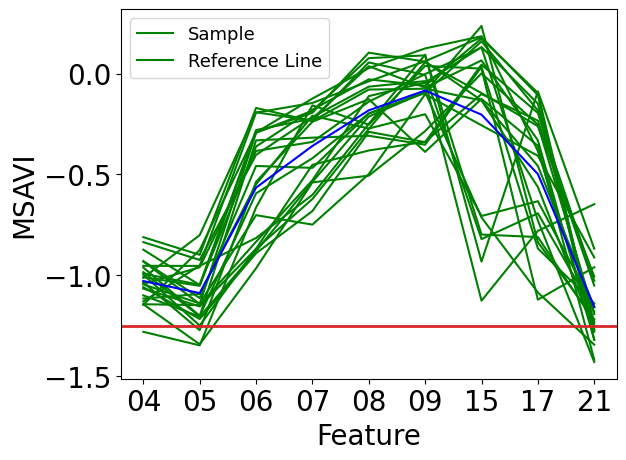

In [ ]:
class_0 = sample_rest_cotton[(sample_rest_cotton["class"] == 0)]
y = class_0[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
for i in range(len(y)):
  l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[1], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
# ax.legend(handles=[l1, l2], labels=['corn sample', 'unknown crop'], loc='best', prop={'size':13})
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
plt.show()
# plt.savefig('5.tif',dpi=330,format='tif',bbox_inches='tight')
# files.download('5.tif')

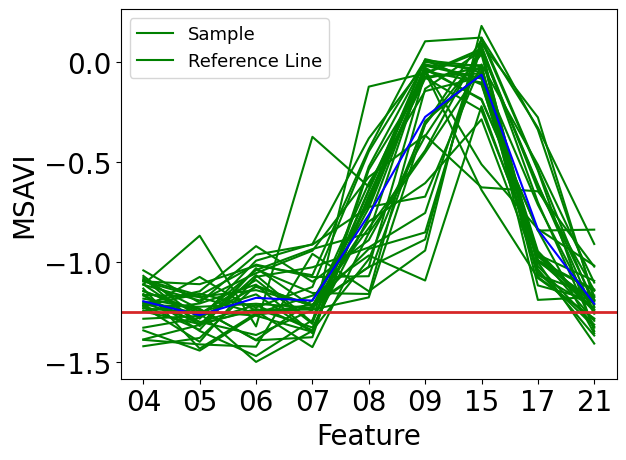

In [ ]:
class_1 = sample_rest_cotton[(sample_rest_cotton["class"] == 1)]
y = class_1[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
for i in range(len(y)):
  l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[2], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
# ax.legend(handles=[l1, l2], labels=['corn sample', 'unknown crop'], loc='best', prop={'size':13})
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
plt.show()
# plt.savefig('5.tif',dpi=330,format='tif',bbox_inches='tight')
# files.download('5.tif')

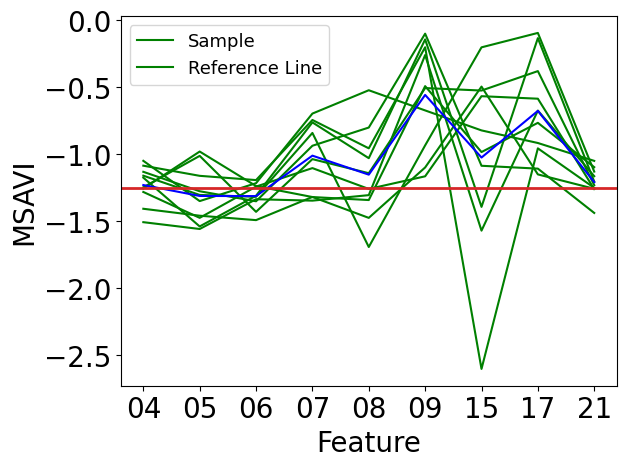

In [ ]:
class_2 = sample_rest_cotton[(sample_rest_cotton["class"] == 2)]
y = class_2[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
for i in range(len(y)):
  l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[0], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
# ax.legend(handles=[l1, l2], labels=['corn sample', 'unknown crop'], loc='best', prop={'size':13})
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
plt.show()
# plt.savefig('5.tif',dpi=330,format='tif',bbox_inches='tight')
# files.download('5.tif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

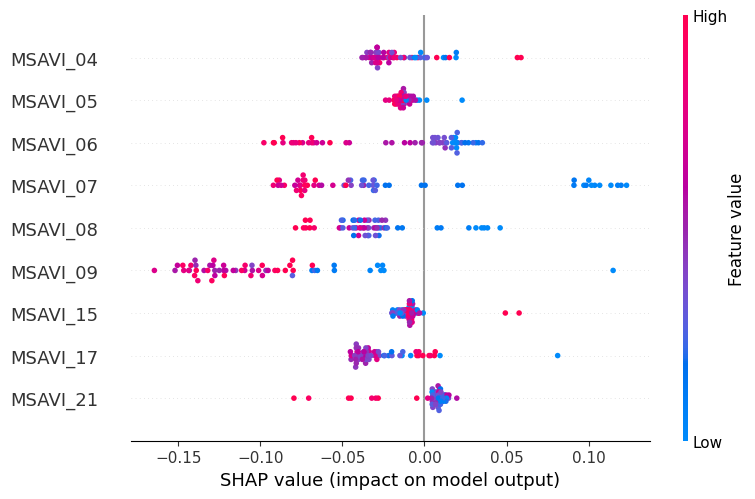

In [ ]:
Class = pd.concat([class_0, class_1])
sample_rest_X, sample_rest_y = Class[feat_labels].iloc[:, :-1], Class[feat_labels].iloc[:, -1]
have_x = sample_rest_X
explainer = shap.TreeExplainer(regr4)
shap_values = explainer.shap_values(have_x)
shap_obj = explainer(have_x)
shap_values2 = copy.deepcopy(shap_obj)
shap_values2.values = shap_obj.values[:,:,1]
shap_values2.base_values = shap_obj.base_values[:,1]
shap.initjs()
shap.summary_plot(shap_values=shap_values2.values,
                  features=have_x,
                  sort=False,
                  show=False)
plt.savefig('5.tif',dpi=330,format='tif',bbox_inches='tight')
files.download('5.tif')

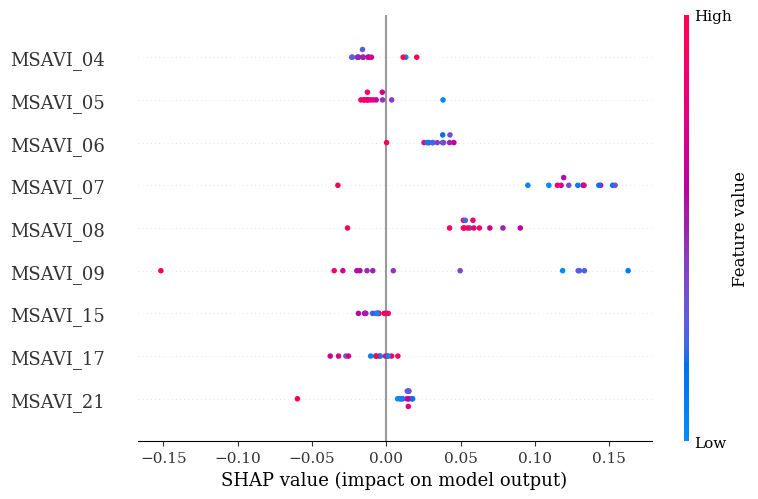

In [ ]:
sample_delete_cotton = sample_delete[(sample_delete["index"] == 0) & (sample_delete["Crop"] == "corn")]
sample_delete_X, sample_delete_y = sample_delete_cotton[feat_labels].iloc[:, :-1], sample_delete_cotton[feat_labels].iloc[:, -1]
have_x = sample_delete_X
explainer = shap.TreeExplainer(regr4)
shap_values = explainer.shap_values(have_x)
shap_obj = explainer(have_x)
shap_values2 = copy.deepcopy(shap_obj)
shap_values2.values = shap_obj.values[:,:,1]
shap_values2.base_values = shap_obj.base_values[:,1]
shap.initjs()
mpl.rc('font', family='serif')
shap.summary_plot(shap_values=shap_values2.values,
                  features=have_x,
                  sort=False,
                  show=False)
# plt.savefig('6.tif',dpi=330,format='tif',bbox_inches='tight')
# files.download('6.tif')

In [ ]:
sample_delete_cotton

C1  C2  C3  C4  Crop Irrigate         Lat        Lon  MSAVI_00  MSAVI_01  \
24   1   0   0   0  corn      Man   41.711111   81.58339 -1.339615 -2.153653   
37   0   1   0   1  corn      Man  41.2959796  83.112261 -1.078693 -1.203700   
54   0   0   1   1  corn       Di   41.617369  81.417523 -1.443177 -2.328839   
55   0   0   1   1  corn       Di     41.6173    81.4545 -1.397696 -2.462918   
56   0   0   1   1  corn       Di   41.714007  81.305581 -1.434657 -3.500195   
57   0   0   1   1  corn      Gou    41.83432   81.84855 -1.430395 -1.479946   
58   0   0   1   1  corn      Gou   41.711861  81.126113 -1.529050 -3.096410   
59   0   0   1   1  corn      Gou   41.628607  81.154434 -1.291570 -3.124706   
60   0   0   1   1  corn      Man   41.629519  81.224486 -1.350556 -2.222486   
63   0   1   1   1  corn      Gou    41.66668   81.15926 -1.318930 -3.071724   
64   0   1   1   1  corn      Man   41.666546  81.533287 -1.344603 -2.509557   
72   1   0   1   1  corn      Gou    41.65068   81.15775 -1.234788 -3.168463   
73   1   1   1   1  corn      Gou   41.741694   81.06076 -1.815372 -3.363440   
74   1   1   1   1  corn      Man    41.66733   81.61705 -1.294810 -1.840770   

    ...  NDVI_max_16  NDVI_max_17  NDVI_max_18  NDVI_max_19  NDVI_max_20  \
24  ...    -0.359538    -1.302312    -1.324993    -1.274381    -1.295135   
37  ...    -0.817729    -0.878741    -0.980868    -0.945434    -0.961355   
54  ...    -0.204327    -0.629495    -0.902824    -1.519205    -1.363097   
55  ...    -0.204676    -0.492214    -0.830215    -1.220472    -1.067326   
56  ...    -0.114221    -0.390637    -0.733765    -0.894764    -1.515185   
57  ...    -1.237569    -1.315437    -1.393048    -1.492056    -1.436951   
58  ...    -0.215438    -0.394016    -0.857891    -0.763718    -1.672013   
59  ...    -0.954482    -1.149992    -1.255472    -1.266949    -1.259927   
60  ...    -0.235836    -0.544107    -0.796247    -1.740331    -1.318506   
63  ...    -0.163317    -0.256964    -0.541342    -1.045855    -1.307437   
64  ...    -0.425847    -0.875223    -1.240425    -0.984505    -1.291622   
72  ...    -0.274818    -0.520301    -1.280758    -2.002591    -1.441303   
73  ...    -0.296469    -0.542817    -1.155069    -0.816508    -1.116438   
74  ...    -0.131314    -0.278948    -0.706955    -1.472676    -1.442558   

    NDVI_max_21               Number  Salinity  index  pred  
24    -1.388426                   36      1.44      0     0  
37    -0.992887  842011C20181009A085      1.10      0     0  
54    -1.166345                   20      1.46      0     0  
55    -1.170252                   21      1.53      0     0  
56    -1.295332                   39      1.95      0     0  
57    -1.613748                    2      1.85      0     0  
58    -1.616064                    5      1.55      0     0  
59    -1.334272                   10      1.83      0     0  
60    -1.125881                   14      1.72      0     0  
63    -1.412195                    8      1.97      0     0  
64    -1.323302                   31      1.18      0     0  
72    -1.409657                    9      1.47      0     0  
73    -1.219601                   25      1.86      0     0  
74    -1.401167                   37      1.48      0     0  

[14 rows x 57 columns]

In [ ]:
from sklearn.cluster import KMeans
import joblib
import numpy
import time
import matplotlib.pyplot as plt
from google.colab import files

sample_delete_X = sample_delete_cotton[label]
estimator = KMeans(n_clusters=2)#构造聚类器
estimator.fit(sample_delete_X)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和

result = estimator.fit_predict(sample_delete_X)

print("Predicting result: ", result)

Predicting result:  [0 0 0 0 0 0 0 1 0 0 0 0 0 0]


In [ ]:
sample_delete_X["class"] = result
sample_delete_X

NDVI_max_04  NDVI_max_05  NDVI_max_06  NDVI_max_07  NDVI_max_08  \
24    -1.358777    -1.270199    -1.204331    -1.512566    -1.133690   
37    -1.200555    -1.275427    -1.108360    -1.226931    -1.040739   
54    -1.464629    -1.503911    -1.439009    -1.238174    -1.550543   
55    -1.428542    -1.153976    -1.780145    -1.288192    -1.574632   
56    -1.336611    -1.106001    -1.507543    -1.323250    -1.442601   
57    -1.406620    -1.572638    -1.520658    -1.401162    -1.353602   
58    -1.445765    -1.667783    -1.680513    -1.095720    -1.658738   
59    -1.233703    -1.414321    -1.334661    -1.255267    -1.643836   
60    -1.433805    -1.519448    -1.486025    -1.112071    -1.525596   
63    -1.072009    -1.296327    -1.398875    -1.180521    -1.521487   
64    -1.102708    -1.543785    -1.487674    -1.352026    -1.415149   
72    -1.263950    -1.404491    -1.373701    -1.441982    -1.460178   
73    -0.901818    -1.174309    -1.237226    -1.565065    -1.491314   
74    -1.469458    -1.374786    -1.625745    -1.510961    -1.373595   

    NDVI_max_09  NDVI_max_15  NDVI_max_17  NDVI_max_21  class  
24    -0.375403     0.068468    -1.302312    -1.388426      0  
37    -1.086937    -0.789063    -0.878741    -0.992887      0  
54    -0.228371    -0.665868    -0.629495    -1.166345      0  
55    -0.568328    -0.511606    -0.492214    -1.170252      0  
56    -0.322016    -0.990998    -0.390637    -1.295332      0  
57    -1.291572    -0.954468    -1.315437    -1.613748      0  
58    -1.074554    -1.155998    -0.394016    -1.616064      0  
59    -1.451143    -2.877019    -1.149992    -1.334272      1  
60    -0.403627    -0.847411    -0.544107    -1.125881      0  
63    -0.625810    -1.382662    -0.256964    -1.412195      0  
64    -0.295943    -0.199702    -0.875223    -1.323302      0  
72     0.118021    -0.616792    -0.520301    -1.409657      0  
73    -1.039119    -0.405364    -0.542817    -1.219601      0  
74    -1.121861     0.126415    -0.278948    -1.401167      0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

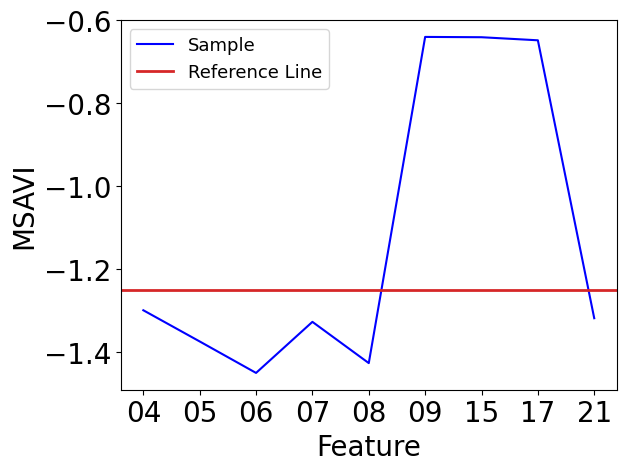

In [ ]:
class_0 = sample_delete_X[(sample_delete_X["class"] == 0)]
y = class_0[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
# for i in range(len(y)):
#   l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[0], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
# ax.legend(handles=[l1, l2], labels=['corn sample', 'unknown crop'], loc='best', prop={'size':13})
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
# plt.show()
plt.savefig('5.tif',dpi=330,format='tif',bbox_inches='tight')
files.download('5.tif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

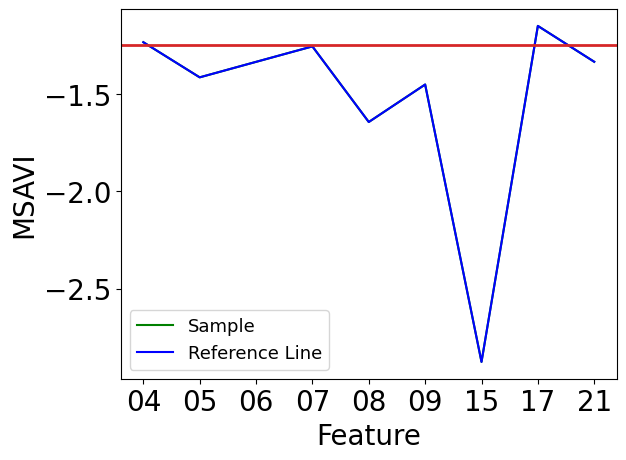

In [ ]:
class_1 = sample_delete_X[(sample_delete_X["class"] == 1)]
y = class_1[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
for i in range(len(y)):
  l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[1], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
# ax.legend(handles=[l1, l2], labels=['corn sample', 'unknown crop'], loc='best', prop={'size':13})
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
# plt.show()
plt.savefig('5.tif',dpi=330,format='tif',bbox_inches='tight')
files.download('5.tif')

#### 玉米有盐碱样本

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

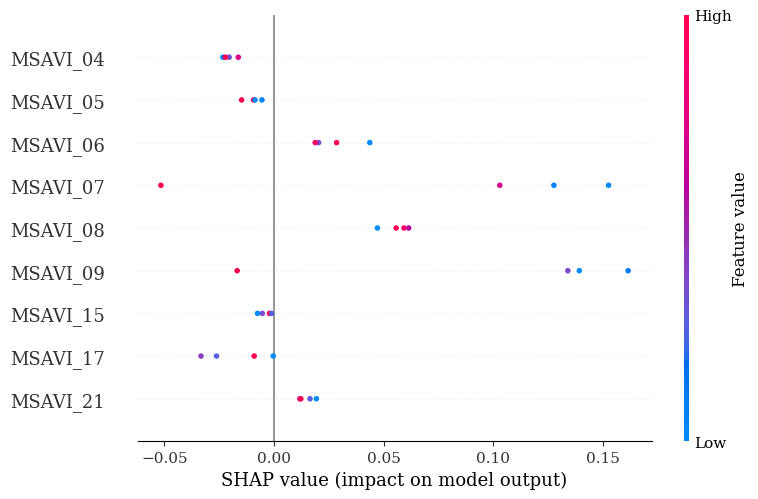

In [ ]:
sample_rest_cotton = sample_rest[(sample_rest["index"] == 1) & (sample_rest["Crop"] == "corn") & (sample_rest['Salinity'] < 3.0) & (sample_rest['Salinity'] > 1.0)]
sample_rest_X, sample_rest_y = sample_rest_cotton[feat_labels].iloc[:, :-1], sample_rest_cotton[feat_labels].iloc[:, -1]
have_x = sample_rest_X
explainer = shap.TreeExplainer(regr4)
shap_values = explainer.shap_values(have_x)
shap_obj = explainer(have_x)
shap_values2 = copy.deepcopy(shap_obj)
shap_values2.values = shap_obj.values[:,:,1]
shap_values2.base_values = shap_obj.base_values[:,1]
shap.initjs()
mpl.rc('font', family='serif')
shap.summary_plot(shap_values=shap_values2.values,
                  features=have_x,
                  sort=False,
                  show=False)
plt.savefig('7.tif',dpi=330,format='tif',bbox_inches='tight')
files.download('7.tif')

In [ ]:
from sklearn.cluster import KMeans
import joblib
import numpy
import time
import matplotlib.pyplot as plt
from google.colab import files

sample_rest_X = sample_rest_cotton[label]
estimator = KMeans(n_clusters=3)#构造聚类器
estimator.fit(sample_rest_X)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和

result = estimator.fit_predict(sample_rest_X)

print("Predicting result: ", result)

Predicting result:  [0 2 1 1]


In [ ]:
sample_rest_X["class"] = result
sample_rest_X

NDVI_max_04  NDVI_max_05  NDVI_max_06  NDVI_max_07  NDVI_max_08  \
235    -1.377156    -1.217011    -1.227509    -1.061553    -1.480590   
238    -1.593523    -1.708480    -1.671937    -1.432580    -1.695371   
239    -1.346674    -1.405979    -1.506039    -1.550998    -1.509446   
242    -1.250495    -1.526819    -1.350453    -1.265328    -1.449190   

     NDVI_max_09  NDVI_max_15  NDVI_max_17  NDVI_max_21  class  
235    -0.524033    -2.578678    -0.471596    -1.050052      0  
238    -1.486882    -1.165451    -1.075885    -1.366403      2  
239    -0.343728    -1.126686    -1.095985    -1.275409      1  
242    -0.841366    -0.504506    -0.610605    -1.247262      1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

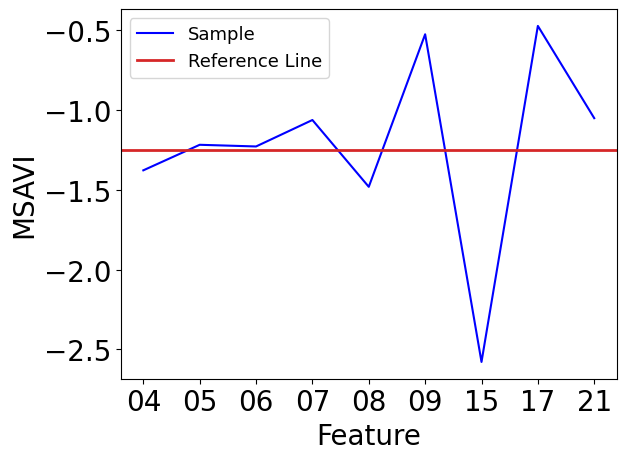

In [ ]:
class_0 = sample_rest_X[(sample_rest_X["class"] == 0)]
y = class_0[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
# for i in range(len(y)):
#   l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[0], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
# ax.legend(handles=[l1, l2], labels=['corn sample', 'unknown crop'], loc='best', prop={'size':13})
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
# plt.show()
plt.savefig('5.tif',dpi=330,format='tif',bbox_inches='tight')
files.download('5.tif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

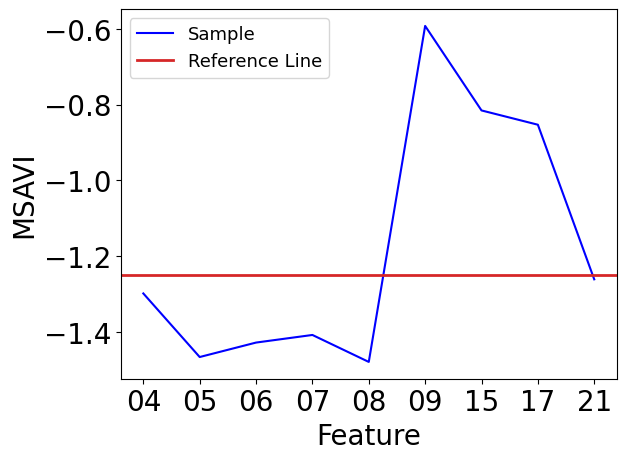

In [ ]:
class_1 = sample_rest_X[(sample_rest_X["class"] == 1)]
y = class_1[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
# for i in range(len(y)):
#   l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[1], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
# ax.legend(handles=[l1, l2], labels=['corn sample', 'unknown crop'], loc='best', prop={'size':13})
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
# plt.show()
plt.savefig('5.tif',dpi=330,format='tif',bbox_inches='tight')
files.download('5.tif')

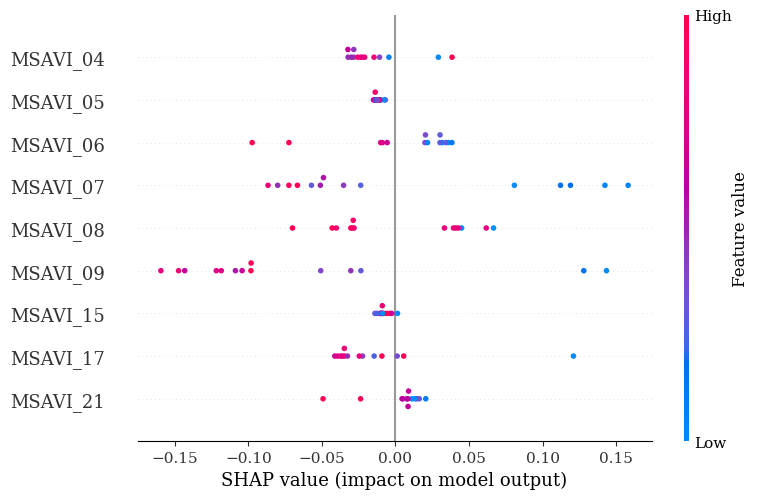

In [ ]:
sample_delete_cotton = sample_delete[(sample_delete["index"] == 1) & (sample_delete["Crop"] == "corn")]
sample_delete_X, sample_delete_y = sample_delete_cotton[feat_labels].iloc[:, :-1], sample_delete_cotton[feat_labels].iloc[:, -1]
have_x = sample_delete_X
explainer = shap.TreeExplainer(regr4)
shap_values = explainer.shap_values(have_x)
shap_obj = explainer(have_x)
shap_values2 = copy.deepcopy(shap_obj)
shap_values2.values = shap_obj.values[:,:,1]
shap_values2.base_values = shap_obj.base_values[:,1]
shap.initjs()
mpl.rc('font', family='serif')
shap.summary_plot(shap_values=shap_values2.values,
                  features=have_x,
                  sort=False,
                  show=False)
# plt.savefig('8.tif',dpi=330,format='tif',bbox_inches='tight')
# files.download('8.tif')

In [ ]:
sample_delete_cotton

C1  C2  C3  C4  Crop Irrigate         Lat         Lon  MSAVI_00  MSAVI_01  \
5    1   1   0   0  corn      Man  41.5704664  82.9378338 -1.053239 -1.133332   
11   0   0   0   0  corn      Man   41.822184   82.208272 -1.315698 -1.552390   
12   0   0   0   0  corn      Man   41.749343   82.121442 -1.024271 -1.389976   
13   0   0   0   0  corn      Man   41.665137   81.761866 -1.304433 -2.123907   
16   1   1   0   0  corn      Gou   41.734711    81.99525 -1.142476 -2.101260   
17   1   1   0   0  corn      Man   41.600876    81.24458 -1.145077 -2.781904   
18   1   1   0   0  corn      Man   41.617583   81.357156 -1.083438 -2.116728   
19   1   1   0   0  corn      Man   41.693039   81.722881 -1.299337 -2.374873   
20   1   1   0   0  corn      Man    41.80298   82.234863 -1.304965 -1.675866   
21   1   1   0   0  corn      Man   41.827995   82.089912 -1.275676 -1.696048   
23   1   0   0   0  corn      Man   41.717522   81.930741 -0.922503 -1.904778   
66   0   1   1   1  corn      Man    41.60215     81.1794 -1.431967 -2.338561   
67   1   1   0   1  corn      Non   41.789928   81.031442 -1.387590 -4.094362   
69   1   0   1   1  corn      Man   41.655363   81.217859 -1.324074 -2.846616   

    ...  NDVI_max_16  NDVI_max_17  NDVI_max_18  NDVI_max_19  NDVI_max_20  \
5   ...    -0.312053    -0.352630    -0.614211    -0.748518    -0.812246   
11  ...    -1.016706    -1.074633    -1.305054    -1.082707    -0.853053   
12  ...    -0.241656    -0.515672    -0.941765    -1.092090    -0.845649   
13  ...    -0.516392    -0.839444    -1.036492    -1.045819    -1.038909   
16  ...    -0.485473    -0.687171    -1.066055    -0.906840    -0.911621   
17  ...    -1.322858    -1.328183    -1.260529    -0.927676    -1.262178   
18  ...    -0.230299    -0.496818    -0.769687    -2.100993    -1.136662   
19  ...    -0.361786    -0.722082    -0.820341    -0.873765    -0.878322   
20  ...    -0.791976    -0.972285    -0.763828    -0.764115    -0.689102   
21  ...    -0.520125    -0.609901    -0.790026    -0.926394    -0.904067   
23  ...    -0.315432    -0.356853    -0.677177    -1.075303    -1.022703   
66  ...    -1.295848    -1.283227    -1.284539    -2.142386    -1.209847   
67  ...    -0.660898    -0.774518    -0.824887    -1.115902    -1.069134   
69  ...    -0.378264    -0.539334    -0.837809    -1.988306    -1.325749   

    NDVI_max_21               Number  Salinity  index  pred  
5     -0.970875  842007C20180925A066      2.20      1     1  
11    -1.389310                   95      2.68      1     1  
12    -1.130838                  100      2.90      1     1  
13    -1.185344                  111      2.14      1     1  
16    -1.170363                   54      2.37      1     1  
17    -1.172281                   15      2.56      1     1  
18    -1.114839                   18      2.53      1     1  
19    -1.159602                   77      2.23      1     1  
20    -0.925187                   93      2.11      1     1  
21    -1.092618                  106      2.11      1     1  
23    -1.243374                  117      2.30      1     1  
66    -1.218853                   27      2.38      1     1  
67    -1.146182                  130      2.87      1     1  
69    -1.377977                   12      2.31      1     1  

[14 rows x 57 columns]

In [ ]:
from sklearn.cluster import KMeans
import joblib
import numpy
import time
import matplotlib.pyplot as plt
from google.colab import files

sample_delete_X = sample_delete_cotton[label]
estimator = KMeans(n_clusters=3)#构造聚类器
estimator.fit(sample_delete_X)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和

result = estimator.fit_predict(sample_delete_X)

print("Predicting result: ", result)

Predicting result:  [0 2 0 2 2 1 1 2 2 0 0 1 0 1]


In [ ]:
sample_delete_cotton["class"] = result
sample_delete_cotton

C1  C2  C3  C4  Crop Irrigate         Lat         Lon  MSAVI_00  MSAVI_01  \
5    1   1   0   0  corn      Man  41.5704664  82.9378338 -1.053239 -1.133332   
11   0   0   0   0  corn      Man   41.822184   82.208272 -1.315698 -1.552390   
12   0   0   0   0  corn      Man   41.749343   82.121442 -1.024271 -1.389976   
13   0   0   0   0  corn      Man   41.665137   81.761866 -1.304433 -2.123907   
16   1   1   0   0  corn      Gou   41.734711    81.99525 -1.142476 -2.101260   
17   1   1   0   0  corn      Man   41.600876    81.24458 -1.145077 -2.781904   
18   1   1   0   0  corn      Man   41.617583   81.357156 -1.083438 -2.116728   
19   1   1   0   0  corn      Man   41.693039   81.722881 -1.299337 -2.374873   
20   1   1   0   0  corn      Man    41.80298   82.234863 -1.304965 -1.675866   
21   1   1   0   0  corn      Man   41.827995   82.089912 -1.275676 -1.696048   
23   1   0   0   0  corn      Man   41.717522   81.930741 -0.922503 -1.904778   
66   0   1   1   1  corn      Man    41.60215     81.1794 -1.431967 -2.338561   
67   1   1   0   1  corn      Non   41.789928   81.031442 -1.387590 -4.094362   
69   1   0   1   1  corn      Man   41.655363   81.217859 -1.324074 -2.846616   

    ...  NDVI_max_17  NDVI_max_18  NDVI_max_19  NDVI_max_20  NDVI_max_21  \
5   ...    -0.352630    -0.614211    -0.748518    -0.812246    -0.970875   
11  ...    -1.074633    -1.305054    -1.082707    -0.853053    -1.389310   
12  ...    -0.515672    -0.941765    -1.092090    -0.845649    -1.130838   
13  ...    -0.839444    -1.036492    -1.045819    -1.038909    -1.185344   
16  ...    -0.687171    -1.066055    -0.906840    -0.911621    -1.170363   
17  ...    -1.328183    -1.260529    -0.927676    -1.262178    -1.172281   
18  ...    -0.496818    -0.769687    -2.100993    -1.136662    -1.114839   
19  ...    -0.722082    -0.820341    -0.873765    -0.878322    -1.159602   
20  ...    -0.972285    -0.763828    -0.764115    -0.689102    -0.925187   
21  ...    -0.609901    -0.790026    -0.926394    -0.904067    -1.092618   
23  ...    -0.356853    -0.677177    -1.075303    -1.022703    -1.243374   
66  ...    -1.283227    -1.284539    -2.142386    -1.209847    -1.218853   
67  ...    -0.774518    -0.824887    -1.115902    -1.069134    -1.146182   
69  ...    -0.539334    -0.837809    -1.988306    -1.325749    -1.377977   

                 Number  Salinity  index  pred  class  
5   842007C20180925A066      2.20      1     1      0  
11                   95      2.68      1     1      2  
12                  100      2.90      1     1      0  
13                  111      2.14      1     1      2  
16                   54      2.37      1     1      2  
17                   15      2.56      1     1      1  
18                   18      2.53      1     1      1  
19                   77      2.23      1     1      2  
20                   93      2.11      1     1      2  
21                  106      2.11      1     1      0  
23                  117      2.30      1     1      0  
66                   27      2.38      1     1      1  
67                  130      2.87      1     1      0  
69                   12      2.31      1     1      1  

[14 rows x 58 columns]

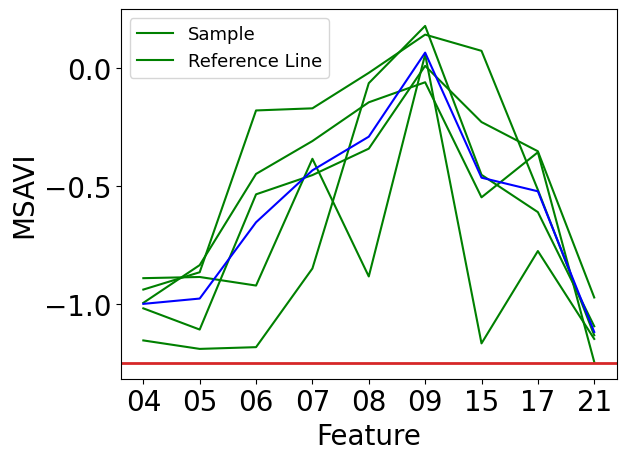

In [ ]:
class_0 = sample_delete_cotton[(sample_delete_cotton["class"] == 0)]
y = class_0[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
for i in range(len(y)):
  l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[0], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
# ax.legend(handles=[l1, l2], labels=['corn sample', 'unknown crop'], loc='best', prop={'size':13})
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
plt.show()
# plt.savefig('5.tif',dpi=330,format='tif',bbox_inches='tight')
# files.download('5.tif')

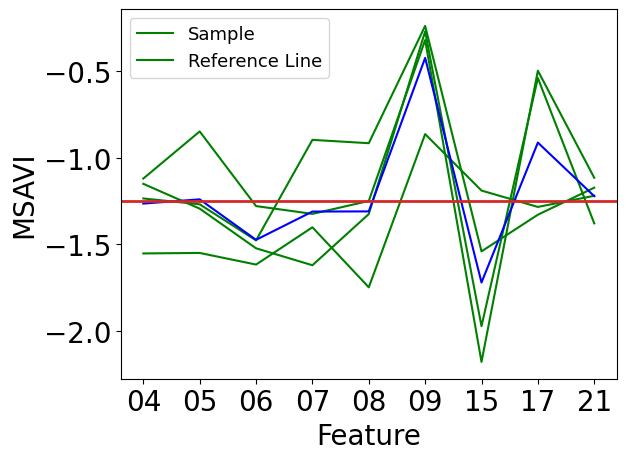

In [ ]:
class_1 = sample_delete_cotton[(sample_delete_cotton["class"] == 1)]
y = class_1[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
for i in range(len(y)):
  l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[1], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
# ax.legend(handles=[l1, l2], labels=['corn sample', 'unknown crop'], loc='best', prop={'size':13})
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
plt.show()
# plt.savefig('5.tif',dpi=330,format='tif',bbox_inches='tight')
# files.download('5.tif')

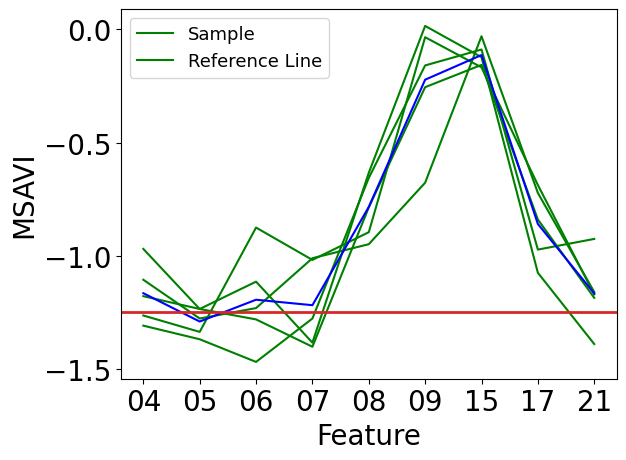

In [ ]:
class_2 = sample_delete_cotton[(sample_delete_cotton["class"] == 2)]
y = class_2[label].values
# X = list(range(22))
X = ['04', '05', '06', '07', '08', '09', '15', '17', '21']
fig, ax = plt.subplots()
for i in range(len(y)):
  l1, = plt.plot(X, y[i], color='green')
plt.plot(X, centroids[2], '-b')
ax.axhline(y=-1.25, linewidth=2, color='#d62728')
# l2, = plt.plot(X, other, color='gray')
# ax.legend(handles=[l1, l2], labels=['corn sample', 'unknown crop'], loc='best', prop={'size':13})
ax.legend(labels=['Sample', 'Reference Line'], loc='best', prop={'size':13})
ax.set_xlabel('Feature',size=20)
ax.set_ylabel('MSAVI',size=20)
ax.tick_params(axis='y',labelsize=20)
ax.tick_params(axis='x',labelsize=20)
plt.show()
# plt.savefig('5.tif',dpi=330,format='tif',bbox_inches='tight')
# files.download('5.tif')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

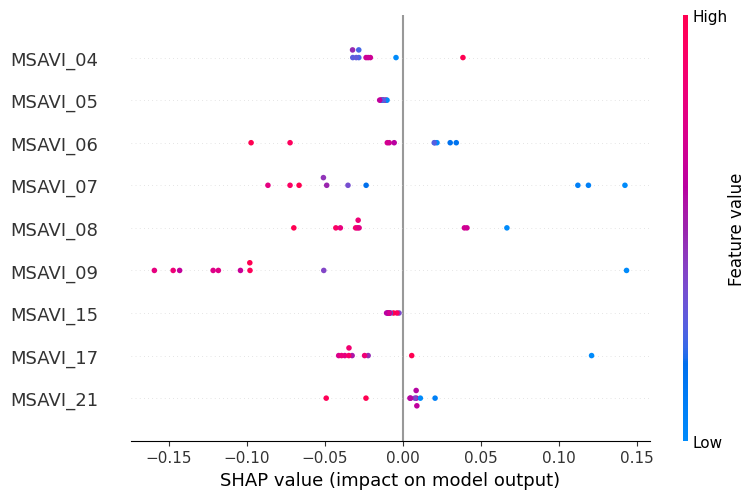

In [ ]:
Class = pd.concat([class_0, class_2])
sample_rest_X, sample_rest_y = Class[feat_labels].iloc[:, :-1], Class[feat_labels].iloc[:, -1]
have_x = sample_rest_X
explainer = shap.TreeExplainer(regr4)
shap_values = explainer.shap_values(have_x)
shap_obj = explainer(have_x)
shap_values2 = copy.deepcopy(shap_obj)
shap_values2.values = shap_obj.values[:,:,1]
shap_values2.base_values = shap_obj.base_values[:,1]
shap.initjs()
shap.summary_plot(shap_values=shap_values2.values,
                  features=have_x,
                  sort=False,
                  show=False)
plt.savefig('8.tif',dpi=330,format='tif',bbox_inches='tight')
files.download('8.tif')